##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 图像分类

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://tensorflow.google.cn/tutorials/images/classification"><img src="https://tensorflow.google.cn/images/tf_logo_32px.png">在 TensorFlow.org 上查看</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/images/classification.ipynb"><img src="https://tensorflow.google.cn/images/colab_logo_32px.png">在 Google Colab 中运行 </a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/images/classification.ipynb"><img src="https://tensorflow.google.cn/images/GitHub-Mark-32px.png">在 GitHub 上查看源代码</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/zh-cn/tutorials/images/classification.ipynb"><img src="https://tensorflow.google.cn/images/download_logo_32px.png">下载笔记本</a></td>
</table>

本教程展示了如何使用 `tf.keras.Sequential` 模型对花卉图像进行分类，并使用 `tf.keras.utils.image_dataset_from_directory` 加载数据。其中演示了以下概念：

- 从磁盘高效加载数据集。
- 识别过拟合，并应用数据增强和随机失活等技术缓解过拟合。

本教程遵循基本的机器学习工作流：

1. 检查并理解数据
2. 构建输入流水线
3. 构建模型
4. 训练模型
5. 测试模型
6. 改进模型并重复整个过程

此外，该笔记本还演示了如何将[保存的模型](../../../guide/saved_model.ipynb)转换为 [TensorFlow Lite](https://tensorflow.google.cn/lite/) 模型，以便在移动设备、嵌入式设备和 IoT 设备上进行设备端机器学习。

## 设置

导入 TensorFlow 和其他必要的库：

In [45]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## 下载并探索数据集

本教程使用一个包含约 3,700 张花卉照片的数据集。该数据集包含 5 个子目录，每个子目录对应一个类：

```
flower_photo/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```

In [46]:
import pathlib

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos.tar', origin=dataset_url, extract=True)
data_dir = pathlib.Path(data_dir).with_suffix('')

 94502912/228813984 [===========>..................] - ETA: 0s

100671488/228813984 [============>.................] - ETA: 0s

112435200/228813984 [=============>................] - ETA: 0s

126795776/228813984 [===============>..............] - ETA: 0s

141221888/228813984 [=================>............] - ETA: 0s

154722304/228813984 [===================>..........] - ETA: 0s

168861696/228813984 [=====================>........] - ETA: 0s

183418880/228813984 [=======================>......] - ETA: 0s

186892288/228813984 [=======================>......] - ETA: 0s

199401472/228813984 [=========================>....] - ETA: 0s

213590016/228813984 [===========================>..] - ETA: 0s

228745216/228813984 [============================>.] - ETA: 0s

228813984/228813984 [==============================] - 1s 0us/step


下载后，您现在应该拥有一个数据集的副本。总共有 3,670 个图像：

In [47]:
data_dir = pathlib.Path('/root/.keras/datasets/flower_photos').with_suffix('')
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


下面是一些玫瑰：

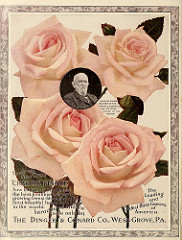

In [48]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

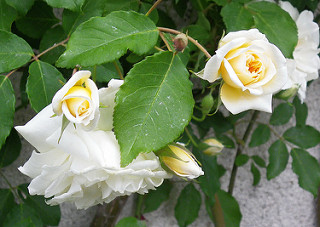

In [49]:
PIL.Image.open(str(roses[1]))

和一些郁金香：

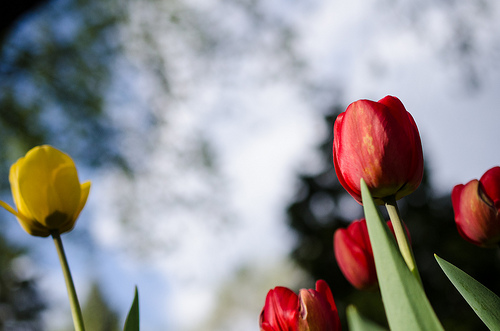

In [50]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

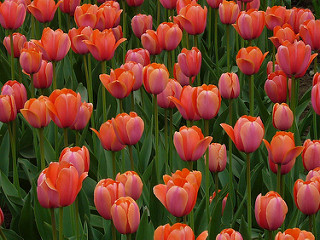

In [51]:
PIL.Image.open(str(tulips[1]))

## 使用 Keras 效用函数加载数据

接下来，使用有用的 `tf.keras.utils.image_dataset_from_directory` 实用工具从磁盘上加载这些图像。只需几行代码就能将磁盘上的图像目录转移到 `tf.data.Dataset`。如果愿意，您也可以访问[加载和预处理图像](../load_data/images.ipynb)教程，从头开始编写您自己的数据加载代码。

### 创建数据集

为加载程序定义一些参数：

In [52]:
batch_size = 32
img_height = 224
img_width = 224

开发模型时，使用验证拆分是一种很好的做法。将 80% 的图像用于训练，将 20% 的图像用于验证。

In [53]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [54]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


您可以在这些数据集的 `class_names` 特性中找到类名称。这些名称按照字母顺序与目录名称相对应。

In [55]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## 呈现数据

下面是训练数据集中的前 9 个图像：

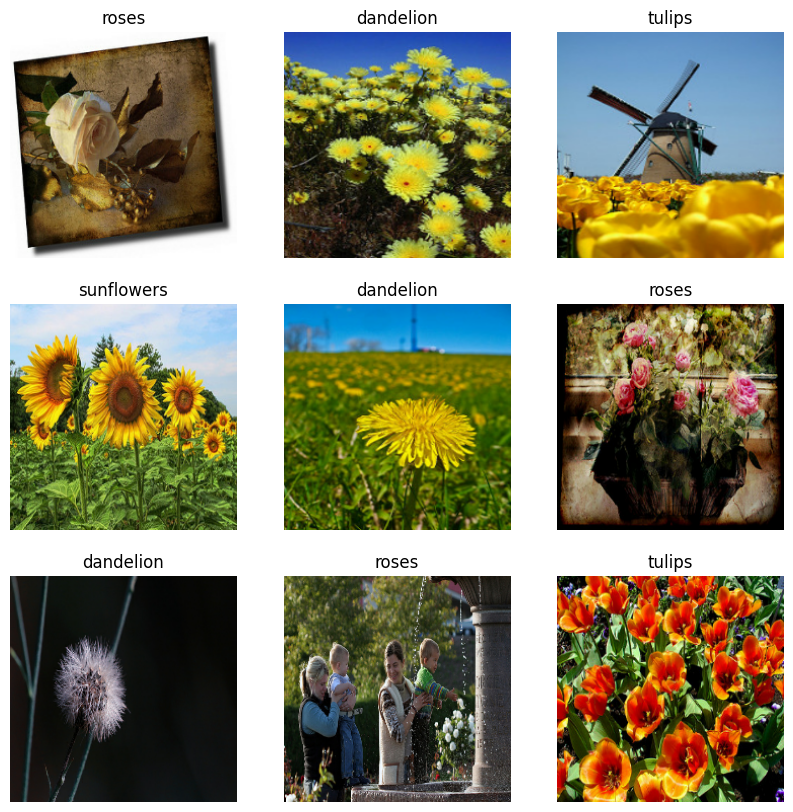

In [56]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

您将把这些数据集传递给 Keras `Model.fit` 方法，以便在本教程的后面部分进行训练。如果愿意，您还可以手动迭代数据集并检索批量图像：

In [57]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


`image_batch` 是形状为 `(32, 180, 180, 3)` 的张量。这是由 32 个形状为 `180x180x3`（最后一个维度是指颜色通道 RGB）的图像组成的批次。`label_batch` 是形状为 `(32,)` 的张量，这些是 32 个图像的对应标签。

您可以在 `image_batch` 和 `labels_batch` 张量上调用 `.numpy()`，将其转换为 `numpy.ndarray`。


## 配置数据集以提高性能

请确保使用缓冲预提取，以便从磁盘产生数据，而不会阻塞 I/O。这是您在加载数据时应该使用的两种重要方法。

- 在第一个周期期间从磁盘加载图像后，`Dataset.cache()` 会将这些图像保留在内存中。这将确保在训练模型时数据集不会成为瓶颈。如果数据集太大无法装入内存，您也可以使用此方法创建高性能的磁盘缓存。
- `Dataset.prefetch()` 会在训练时将数据预处理和模型执行重叠。

感兴趣的读者可以在[使用 tf.data API 获得更佳性能](../../guide/data_performance.ipynb)指南的*预提取*部分了解更多有关这两种方法的详细信息，以及如何将数据缓存到磁盘。

In [58]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## 标准化数据

RGB 通道值在 `[0, 255]` 范围内。这对于神经网络来说并不理想；一般而言，您应当设法使您的输入值变小。

在这里，我们通过使用 `tf.keras.layers.Rescaling` 将值标准化为在 `[0, 1]` 范围内。

In [59]:
normalization_layer = layers.Rescaling(1./255)

可以通过两种方式使用该层。您可以通过调用 `Dataset.map` 将其应用于数据集：

In [60]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.9297445


或者，您可以在模型定义中包括该层，从而简化部署。在这里，请使用第二种方式。

注：您之前使用 `tf.keras.utils.image_dataset_from_directory` 的 `image_size` 参数调整了图像大小。如果您还希望在模型中包括调整大小的逻辑，可以使用 `tf.keras.layers.Resizing` 层。

## 基本 Keras 模型

### 创建模型

Keras [序贯](https://tensorflow.google.cn/guide/keras/sequential_model)模型由三个卷积块 (`tf.keras.layers.Conv2D`) 组成，每个卷积块都有一个最大池化层 (`tf.keras.layers.MaxPooling2D`)。有一个全连接层 (`tf.keras.layers.Dense`)，上方有 128 个单元，由 ReLU 激活函数 (`'relu'`) 激活。此模型尚未针对高准确率进行调整；本教程的目标是展示一种标准方式。

In [61]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### 编译模型

对于本教程，选择 `tf.keras.optimizers.Adam` 优化器和 `tf.keras.losses.SparseCategoricalCrossentropy` 损失函数。要查看每个训练周期的训练和验证准确率，请将 `metrics` 参数传递给 `Model.compile`。

In [62]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### 模型摘要

使用 Keras `Model.summary` 方法查看网络的所有层：

In [63]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 112, 112, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 56, 56, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 56, 56, 64)       

 conv2d (Conv2D)             (None, 180, 180, 16)      448       


 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         


 D)                                                              


 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      


 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         


 g2D)                                                            


 conv2d_2 (Conv2D)           (None, 45, 45, 64)        18496     


 max_pooling2d_2 (MaxPoolin  (None, 22, 22, 64)        0         


 g2D)                                                            


 flatten (Flatten)           (None, 30976)             0         


 dense (Dense)               (None, 128)               3965056   


 dense_1 (Dense)             (None, 5)                 645       


Total params: 3989285 (15.22 MB)


Trainable params: 3989285 (15.22 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


### 训练模型

使用 Keras `Model.fit` 方法将模型训练 10 个 周期：

In [64]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 2s 17ms/step - loss: 1.3308 - accuracy: 0.4601 - val_loss: 1.0872 - val_accuracy: 0.5559
Epoch 2/10
92/92 [==============================] - 1s 13ms/step - loss: 0.9419 - accuracy: 0.6393 - val_loss: 0.9273 - val_accuracy: 0.6294
Epoch 3/10
92/92 [==============================] - 1s 13ms/step - loss: 0.6860 - accuracy: 0.7401 - val_loss: 0.8987 - val_accuracy: 0.6608
Epoch 4/10
92/92 [==============================] - 1s 13ms/step - loss: 0.4210 - accuracy: 0.8498 - val_loss: 0.9776 - val_accuracy: 0.6703
Epoch 5/10
92/92 [==============================] - 1s 13ms/step - loss: 0.2296 - accuracy: 0.9254 - val_loss: 1.1675 - val_accuracy: 0.6553
Epoch 6/10
92/92 [==============================] - 1s 13ms/step - loss: 0.0930 - accuracy: 0.9765 - val_loss: 1.4503 - val_accuracy: 0.6444
Epoch 7/10
92/92 [==============================] - 1s 13ms/step - loss: 0.1084 - accuracy: 0.9683 - val_loss: 1.8251 - val_accuracy: 0.5681
Epoch 8/10
92

15/92 [===>..........................] - ETA: 5s - loss: 1.9056 - accuracy: 0.2119

18/92 [====>.........................] - ETA: 4s - loss: 1.8536 - accuracy: 0.2342

21/92 [=====>........................] - ETA: 3s - loss: 1.8167 - accuracy: 0.2380

24/92 [======>.......................] - ETA: 3s - loss: 1.7875 - accuracy: 0.2553

27/92 [=======>......................] - ETA: 3s - loss: 1.7624 - accuracy: 0.2664

30/92 [========>.....................] - ETA: 2s - loss: 1.7356 - accuracy: 0.2689

33/92 [=========>....................] - ETA: 2s - loss: 1.7187 - accuracy: 0.2653

36/92 [==========>...................] - ETA: 2s - loss: 1.6984 - accuracy: 0.2780

39/92 [===========>..................] - ETA: 1s - loss: 1.6812 - accuracy: 0.2887

42/92 [============>.................] - ETA: 1s - loss: 1.6623 - accuracy: 0.2987

45/92 [=============>................] - ETA: 1s - loss: 1.6472 - accuracy: 0.3045

48/92 [==============>...............] - ETA: 1s - loss: 1.6352 - accuracy: 0.3115

51/92 [===============>..............] - ETA: 1s - loss: 1.6268 - accuracy: 0.3183

54/92 [================>.............] - ETA: 1s - loss: 1.6155 - accuracy: 0.3209

57/92 [=================>............] - ETA: 1s - loss: 1.6033 - accuracy: 0.3254

60/92 [==================>...........] - ETA: 0s - loss: 1.5900 - accuracy: 0.3295

63/92 [===================>..........] - ETA: 0s - loss: 1.5775 - accuracy: 0.3381

66/92 [====================>.........] - ETA: 0s - loss: 1.5618 - accuracy: 0.3441

69/92 [=====================>........] - ETA: 0s - loss: 1.5473 - accuracy: 0.3486

72/92 [======================>.......] - ETA: 0s - loss: 1.5345 - accuracy: 0.3532

75/92 [=======================>......] - ETA: 0s - loss: 1.5220 - accuracy: 0.3570

78/92 [========================>.....] - ETA: 0s - loss: 1.5101 - accuracy: 0.3645

81/92 [=========================>....] - ETA: 0s - loss: 1.5036 - accuracy: 0.3630

84/92 [==========================>...] - ETA: 0s - loss: 1.4940 - accuracy: 0.3657

87/92 [===========================>..] - ETA: 0s - loss: 1.4862 - accuracy: 0.3656

90/92 [============================>.] - ETA: 0s - loss: 1.4767 - accuracy: 0.3712

92/92 [==============================] - 7s 34ms/step - loss: 1.4727 - accuracy: 0.3726 - val_loss: 1.3268 - val_accuracy: 0.4305


Epoch 2/10


 1/92 [..............................] - ETA: 1s - loss: 1.3448 - accuracy: 0.4062

 4/92 [>.............................] - ETA: 1s - loss: 1.2624 - accuracy: 0.4453

 7/92 [=>............................] - ETA: 1s - loss: 1.2207 - accuracy: 0.4688

10/92 [==>...........................] - ETA: 1s - loss: 1.2000 - accuracy: 0.4656

13/92 [===>..........................] - ETA: 1s - loss: 1.2060 - accuracy: 0.4880

16/92 [====>.........................] - ETA: 1s - loss: 1.1937 - accuracy: 0.4922

19/92 [=====>........................] - ETA: 1s - loss: 1.1795 - accuracy: 0.4934

22/92 [======>.......................] - ETA: 1s - loss: 1.1667 - accuracy: 0.5028

25/92 [=======>......................] - ETA: 1s - loss: 1.1672 - accuracy: 0.5013

28/92 [========>.....................] - ETA: 1s - loss: 1.1531 - accuracy: 0.5078

31/92 [=========>....................] - ETA: 1s - loss: 1.1552 - accuracy: 0.5081

34/92 [==========>...................] - ETA: 1s - loss: 1.1468 - accuracy: 0.5092

37/92 [===========>..................] - ETA: 1s - loss: 1.1460 - accuracy: 0.5042

40/92 [============>.................] - ETA: 0s - loss: 1.1558 - accuracy: 0.5008

43/92 [=============>................] - ETA: 0s - loss: 1.1479 - accuracy: 0.5080

46/92 [==============>...............] - ETA: 0s - loss: 1.1491 - accuracy: 0.5115

49/92 [==============>...............] - ETA: 0s - loss: 1.1352 - accuracy: 0.5198

52/92 [===============>..............] - ETA: 0s - loss: 1.1272 - accuracy: 0.5222

55/92 [================>.............] - ETA: 0s - loss: 1.1237 - accuracy: 0.5233

58/92 [=================>............] - ETA: 0s - loss: 1.1148 - accuracy: 0.5259

61/92 [==================>...........] - ETA: 0s - loss: 1.1162 - accuracy: 0.5266

64/92 [===================>..........] - ETA: 0s - loss: 1.1143 - accuracy: 0.5298

67/92 [====================>.........] - ETA: 0s - loss: 1.1097 - accuracy: 0.5336

70/92 [=====================>........] - ETA: 0s - loss: 1.1051 - accuracy: 0.5375

73/92 [======================>.......] - ETA: 0s - loss: 1.1013 - accuracy: 0.5394

76/92 [=======================>......] - ETA: 0s - loss: 1.1065 - accuracy: 0.5399

79/92 [========================>.....] - ETA: 0s - loss: 1.1024 - accuracy: 0.5439

82/92 [=========================>....] - ETA: 0s - loss: 1.1003 - accuracy: 0.5446

85/92 [==========================>...] - ETA: 0s - loss: 1.1008 - accuracy: 0.5461

88/92 [===========================>..] - ETA: 0s - loss: 1.1036 - accuracy: 0.5442

91/92 [============================>.] - ETA: 0s - loss: 1.1015 - accuracy: 0.5434

92/92 [==============================] - 2s 21ms/step - loss: 1.0999 - accuracy: 0.5433 - val_loss: 1.0543 - val_accuracy: 0.5790


Epoch 3/10


 1/92 [..............................] - ETA: 1s - loss: 0.9093 - accuracy: 0.6562

 4/92 [>.............................] - ETA: 1s - loss: 1.0058 - accuracy: 0.6250

 7/92 [=>............................] - ETA: 1s - loss: 1.0160 - accuracy: 0.5938

10/92 [==>...........................] - ETA: 1s - loss: 1.0022 - accuracy: 0.6250

13/92 [===>..........................] - ETA: 1s - loss: 0.9932 - accuracy: 0.6154

16/92 [====>.........................] - ETA: 1s - loss: 0.9934 - accuracy: 0.6172

19/92 [=====>........................] - ETA: 1s - loss: 0.9771 - accuracy: 0.6266

22/92 [======>.......................] - ETA: 1s - loss: 0.9690 - accuracy: 0.6349

25/92 [=======>......................] - ETA: 1s - loss: 0.9732 - accuracy: 0.6350

28/92 [========>.....................] - ETA: 1s - loss: 0.9758 - accuracy: 0.6272

31/92 [=========>....................] - ETA: 1s - loss: 0.9553 - accuracy: 0.6331

34/92 [==========>...................] - ETA: 1s - loss: 0.9491 - accuracy: 0.6296

37/92 [===========>..................] - ETA: 1s - loss: 0.9519 - accuracy: 0.6250

40/92 [============>.................] - ETA: 0s - loss: 0.9493 - accuracy: 0.6281

43/92 [=============>................] - ETA: 0s - loss: 0.9520 - accuracy: 0.6279

46/92 [==============>...............] - ETA: 0s - loss: 0.9436 - accuracy: 0.6291

49/92 [==============>...............] - ETA: 0s - loss: 0.9651 - accuracy: 0.6173

52/92 [===============>..............] - ETA: 0s - loss: 0.9657 - accuracy: 0.6172

55/92 [================>.............] - ETA: 0s - loss: 0.9612 - accuracy: 0.6199

58/92 [=================>............] - ETA: 0s - loss: 0.9628 - accuracy: 0.6185

61/92 [==================>...........] - ETA: 0s - loss: 0.9570 - accuracy: 0.6204

64/92 [===================>..........] - ETA: 0s - loss: 0.9552 - accuracy: 0.6211

67/92 [====================>.........] - ETA: 0s - loss: 0.9495 - accuracy: 0.6245

70/92 [=====================>........] - ETA: 0s - loss: 0.9500 - accuracy: 0.6277

73/92 [======================>.......] - ETA: 0s - loss: 0.9471 - accuracy: 0.6293

76/92 [=======================>......] - ETA: 0s - loss: 0.9456 - accuracy: 0.6308

79/92 [========================>.....] - ETA: 0s - loss: 0.9452 - accuracy: 0.6313

82/92 [=========================>....] - ETA: 0s - loss: 0.9431 - accuracy: 0.6353

85/92 [==========================>...] - ETA: 0s - loss: 0.9349 - accuracy: 0.6364

88/92 [===========================>..] - ETA: 0s - loss: 0.9387 - accuracy: 0.6343

91/92 [============================>.] - ETA: 0s - loss: 0.9352 - accuracy: 0.6374

92/92 [==============================] - 2s 21ms/step - loss: 0.9323 - accuracy: 0.6390 - val_loss: 0.9596 - val_accuracy: 0.6090


Epoch 4/10


 1/92 [..............................] - ETA: 1s - loss: 0.6107 - accuracy: 0.8125

 4/92 [>.............................] - ETA: 1s - loss: 0.7087 - accuracy: 0.7266

 7/92 [=>............................] - ETA: 1s - loss: 0.7870 - accuracy: 0.7098

10/92 [==>...........................] - ETA: 1s - loss: 0.7688 - accuracy: 0.7244

13/92 [===>..........................] - ETA: 1s - loss: 0.8061 - accuracy: 0.7034

16/92 [====>.........................] - ETA: 1s - loss: 0.8362 - accuracy: 0.6944

19/92 [=====>........................] - ETA: 1s - loss: 0.8380 - accuracy: 0.6883

22/92 [======>.......................] - ETA: 1s - loss: 0.8428 - accuracy: 0.6839

25/92 [=======>......................] - ETA: 1s - loss: 0.8396 - accuracy: 0.6869

28/92 [========>.....................] - ETA: 1s - loss: 0.8365 - accuracy: 0.6802

31/92 [=========>....................] - ETA: 1s - loss: 0.8310 - accuracy: 0.6819

34/92 [==========>...................] - ETA: 1s - loss: 0.8214 - accuracy: 0.6898

37/92 [===========>..................] - ETA: 1s - loss: 0.8281 - accuracy: 0.6837

40/92 [============>.................] - ETA: 0s - loss: 0.8167 - accuracy: 0.6918

43/92 [=============>................] - ETA: 0s - loss: 0.8116 - accuracy: 0.6966

46/92 [==============>...............] - ETA: 0s - loss: 0.8071 - accuracy: 0.6967

49/92 [==============>...............] - ETA: 0s - loss: 0.8021 - accuracy: 0.7006

52/92 [===============>..............] - ETA: 0s - loss: 0.7982 - accuracy: 0.7005

55/92 [================>.............] - ETA: 0s - loss: 0.8084 - accuracy: 0.6958

58/92 [=================>............] - ETA: 0s - loss: 0.8084 - accuracy: 0.6953

61/92 [==================>...........] - ETA: 0s - loss: 0.8083 - accuracy: 0.6960

64/92 [===================>..........] - ETA: 0s - loss: 0.8027 - accuracy: 0.7000

67/92 [====================>.........] - ETA: 0s - loss: 0.8052 - accuracy: 0.6976

70/92 [=====================>........] - ETA: 0s - loss: 0.8004 - accuracy: 0.6998

73/92 [======================>.......] - ETA: 0s - loss: 0.7959 - accuracy: 0.7015

76/92 [=======================>......] - ETA: 0s - loss: 0.7997 - accuracy: 0.6972

79/92 [========================>.....] - ETA: 0s - loss: 0.8015 - accuracy: 0.6972

82/92 [=========================>....] - ETA: 0s - loss: 0.8003 - accuracy: 0.6976

85/92 [==========================>...] - ETA: 0s - loss: 0.7999 - accuracy: 0.6991

88/92 [===========================>..] - ETA: 0s - loss: 0.7979 - accuracy: 0.7009

91/92 [============================>.] - ETA: 0s - loss: 0.7916 - accuracy: 0.7056

92/92 [==============================] - 2s 21ms/step - loss: 0.7897 - accuracy: 0.7067 - val_loss: 0.9987 - val_accuracy: 0.6063


Epoch 5/10


 1/92 [..............................] - ETA: 1s - loss: 0.7572 - accuracy: 0.7188

 4/92 [>.............................] - ETA: 1s - loss: 0.7410 - accuracy: 0.7344

 7/92 [=>............................] - ETA: 1s - loss: 0.6872 - accuracy: 0.7679

10/92 [==>...........................] - ETA: 1s - loss: 0.6802 - accuracy: 0.7563

13/92 [===>..........................] - ETA: 1s - loss: 0.6445 - accuracy: 0.7596

16/92 [====>.........................] - ETA: 1s - loss: 0.6295 - accuracy: 0.7559

19/92 [=====>........................] - ETA: 1s - loss: 0.6233 - accuracy: 0.7599

22/92 [======>.......................] - ETA: 1s - loss: 0.6090 - accuracy: 0.7642

25/92 [=======>......................] - ETA: 1s - loss: 0.5980 - accuracy: 0.7650

28/92 [========>.....................] - ETA: 1s - loss: 0.6025 - accuracy: 0.7667

31/92 [=========>....................] - ETA: 1s - loss: 0.6046 - accuracy: 0.7681

34/92 [==========>...................] - ETA: 1s - loss: 0.6141 - accuracy: 0.7619

37/92 [===========>..................] - ETA: 1s - loss: 0.6175 - accuracy: 0.7601

40/92 [============>.................] - ETA: 0s - loss: 0.6135 - accuracy: 0.7602

43/92 [=============>................] - ETA: 0s - loss: 0.6095 - accuracy: 0.7609

46/92 [==============>...............] - ETA: 0s - loss: 0.6032 - accuracy: 0.7663

49/92 [==============>...............] - ETA: 0s - loss: 0.6037 - accuracy: 0.7666

52/92 [===============>..............] - ETA: 0s - loss: 0.6024 - accuracy: 0.7692

55/92 [================>.............] - ETA: 0s - loss: 0.6085 - accuracy: 0.7665

58/92 [=================>............] - ETA: 0s - loss: 0.6067 - accuracy: 0.7683

61/92 [==================>...........] - ETA: 0s - loss: 0.6129 - accuracy: 0.7664

64/92 [===================>..........] - ETA: 0s - loss: 0.6207 - accuracy: 0.7642

67/92 [====================>.........] - ETA: 0s - loss: 0.6218 - accuracy: 0.7654

70/92 [=====================>........] - ETA: 0s - loss: 0.6193 - accuracy: 0.7661

73/92 [======================>.......] - ETA: 0s - loss: 0.6183 - accuracy: 0.7689

76/92 [=======================>......] - ETA: 0s - loss: 0.6172 - accuracy: 0.7690

79/92 [========================>.....] - ETA: 0s - loss: 0.6132 - accuracy: 0.7706

82/92 [=========================>....] - ETA: 0s - loss: 0.6132 - accuracy: 0.7726

85/92 [==========================>...] - ETA: 0s - loss: 0.6109 - accuracy: 0.7714

88/92 [===========================>..] - ETA: 0s - loss: 0.6102 - accuracy: 0.7714

91/92 [============================>.] - ETA: 0s - loss: 0.6107 - accuracy: 0.7720

92/92 [==============================] - 2s 21ms/step - loss: 0.6101 - accuracy: 0.7728 - val_loss: 0.9293 - val_accuracy: 0.6594


Epoch 6/10


 1/92 [..............................] - ETA: 1s - loss: 0.5532 - accuracy: 0.8438

 4/92 [>.............................] - ETA: 1s - loss: 0.5315 - accuracy: 0.8281

 7/92 [=>............................] - ETA: 1s - loss: 0.4899 - accuracy: 0.8259

10/92 [==>...........................] - ETA: 1s - loss: 0.4451 - accuracy: 0.8438

13/92 [===>..........................] - ETA: 1s - loss: 0.4302 - accuracy: 0.8558

16/92 [====>.........................] - ETA: 1s - loss: 0.4164 - accuracy: 0.8613

19/92 [=====>........................] - ETA: 1s - loss: 0.4129 - accuracy: 0.8651

22/92 [======>.......................] - ETA: 1s - loss: 0.4262 - accuracy: 0.8565

25/92 [=======>......................] - ETA: 1s - loss: 0.4338 - accuracy: 0.8487

28/92 [========>.....................] - ETA: 1s - loss: 0.4270 - accuracy: 0.8516

31/92 [=========>....................] - ETA: 1s - loss: 0.4226 - accuracy: 0.8548

34/92 [==========>...................] - ETA: 1s - loss: 0.4210 - accuracy: 0.8557

37/92 [===========>..................] - ETA: 1s - loss: 0.4295 - accuracy: 0.8522

40/92 [============>.................] - ETA: 0s - loss: 0.4321 - accuracy: 0.8523

43/92 [=============>................] - ETA: 0s - loss: 0.4269 - accuracy: 0.8539

46/92 [==============>...............] - ETA: 0s - loss: 0.4318 - accuracy: 0.8519

49/92 [==============>...............] - ETA: 0s - loss: 0.4394 - accuracy: 0.8468

52/92 [===============>..............] - ETA: 0s - loss: 0.4344 - accuracy: 0.8496

55/92 [================>.............] - ETA: 0s - loss: 0.4324 - accuracy: 0.8482

58/92 [=================>............] - ETA: 0s - loss: 0.4352 - accuracy: 0.8474

61/92 [==================>...........] - ETA: 0s - loss: 0.4361 - accuracy: 0.8483

64/92 [===================>..........] - ETA: 0s - loss: 0.4358 - accuracy: 0.8466

67/92 [====================>.........] - ETA: 0s - loss: 0.4308 - accuracy: 0.8469

70/92 [=====================>........] - ETA: 0s - loss: 0.4279 - accuracy: 0.8495

73/92 [======================>.......] - ETA: 0s - loss: 0.4246 - accuracy: 0.8509

76/92 [=======================>......] - ETA: 0s - loss: 0.4226 - accuracy: 0.8515

79/92 [========================>.....] - ETA: 0s - loss: 0.4204 - accuracy: 0.8536

82/92 [=========================>....] - ETA: 0s - loss: 0.4234 - accuracy: 0.8505

85/92 [==========================>...] - ETA: 0s - loss: 0.4195 - accuracy: 0.8507

88/92 [===========================>..] - ETA: 0s - loss: 0.4192 - accuracy: 0.8515

91/92 [============================>.] - ETA: 0s - loss: 0.4257 - accuracy: 0.8488

92/92 [==============================] - 2s 21ms/step - loss: 0.4279 - accuracy: 0.8481 - val_loss: 1.1500 - val_accuracy: 0.6322


Epoch 7/10


 1/92 [..............................] - ETA: 1s - loss: 0.2914 - accuracy: 0.8750

 4/92 [>.............................] - ETA: 1s - loss: 0.2730 - accuracy: 0.9141

 7/92 [=>............................] - ETA: 1s - loss: 0.2727 - accuracy: 0.9152

10/92 [==>...........................] - ETA: 1s - loss: 0.2558 - accuracy: 0.9281

13/92 [===>..........................] - ETA: 1s - loss: 0.2612 - accuracy: 0.9255

16/92 [====>.........................] - ETA: 1s - loss: 0.2668 - accuracy: 0.9219

19/92 [=====>........................] - ETA: 1s - loss: 0.2743 - accuracy: 0.9178

22/92 [======>.......................] - ETA: 1s - loss: 0.2897 - accuracy: 0.9077

25/92 [=======>......................] - ETA: 1s - loss: 0.3131 - accuracy: 0.8950

28/92 [========>.....................] - ETA: 1s - loss: 0.3132 - accuracy: 0.8951

31/92 [=========>....................] - ETA: 1s - loss: 0.3129 - accuracy: 0.8921

34/92 [==========>...................] - ETA: 1s - loss: 0.3129 - accuracy: 0.8925

37/92 [===========>..................] - ETA: 1s - loss: 0.3137 - accuracy: 0.8936

40/92 [============>.................] - ETA: 0s - loss: 0.3096 - accuracy: 0.8969

43/92 [=============>................] - ETA: 0s - loss: 0.3039 - accuracy: 0.9006

46/92 [==============>...............] - ETA: 0s - loss: 0.3009 - accuracy: 0.9023

49/92 [==============>...............] - ETA: 0s - loss: 0.3009 - accuracy: 0.9019

52/92 [===============>..............] - ETA: 0s - loss: 0.2992 - accuracy: 0.9028

55/92 [================>.............] - ETA: 0s - loss: 0.3033 - accuracy: 0.9013

58/92 [=================>............] - ETA: 0s - loss: 0.3020 - accuracy: 0.9026

61/92 [==================>...........] - ETA: 0s - loss: 0.3026 - accuracy: 0.9007

64/92 [===================>..........] - ETA: 0s - loss: 0.2984 - accuracy: 0.9025

67/92 [====================>.........] - ETA: 0s - loss: 0.2974 - accuracy: 0.9040

70/92 [=====================>........] - ETA: 0s - loss: 0.2986 - accuracy: 0.9046

73/92 [======================>.......] - ETA: 0s - loss: 0.2941 - accuracy: 0.9064

76/92 [=======================>......] - ETA: 0s - loss: 0.2969 - accuracy: 0.9059

79/92 [========================>.....] - ETA: 0s - loss: 0.2949 - accuracy: 0.9071

82/92 [=========================>....] - ETA: 0s - loss: 0.2977 - accuracy: 0.9056

85/92 [==========================>...] - ETA: 0s - loss: 0.2994 - accuracy: 0.9038

88/92 [===========================>..] - ETA: 0s - loss: 0.2961 - accuracy: 0.9046

91/92 [============================>.] - ETA: 0s - loss: 0.2915 - accuracy: 0.9056

92/92 [==============================] - 2s 21ms/step - loss: 0.2912 - accuracy: 0.9050 - val_loss: 1.1871 - val_accuracy: 0.6376


Epoch 8/10


 1/92 [..............................] - ETA: 1s - loss: 0.0809 - accuracy: 0.9688

 4/92 [>.............................] - ETA: 1s - loss: 0.1329 - accuracy: 0.9609

 7/92 [=>............................] - ETA: 1s - loss: 0.1656 - accuracy: 0.9554

10/92 [==>...........................] - ETA: 1s - loss: 0.1594 - accuracy: 0.9563

13/92 [===>..........................] - ETA: 1s - loss: 0.1671 - accuracy: 0.9519

16/92 [====>.........................] - ETA: 1s - loss: 0.1649 - accuracy: 0.9531

19/92 [=====>........................] - ETA: 1s - loss: 0.1591 - accuracy: 0.9556

22/92 [======>.......................] - ETA: 1s - loss: 0.1785 - accuracy: 0.9460

25/92 [=======>......................] - ETA: 1s - loss: 0.1732 - accuracy: 0.9500

28/92 [========>.....................] - ETA: 1s - loss: 0.1695 - accuracy: 0.9498

31/92 [=========>....................] - ETA: 1s - loss: 0.1662 - accuracy: 0.9506

34/92 [==========>...................] - ETA: 1s - loss: 0.1729 - accuracy: 0.9463

37/92 [===========>..................] - ETA: 1s - loss: 0.1778 - accuracy: 0.9439

40/92 [============>.................] - ETA: 0s - loss: 0.1809 - accuracy: 0.9442

43/92 [=============>................] - ETA: 0s - loss: 0.1824 - accuracy: 0.9437

46/92 [==============>...............] - ETA: 0s - loss: 0.1861 - accuracy: 0.9447

49/92 [==============>...............] - ETA: 0s - loss: 0.1837 - accuracy: 0.9455

52/92 [===============>..............] - ETA: 0s - loss: 0.1819 - accuracy: 0.9463

55/92 [================>.............] - ETA: 0s - loss: 0.1830 - accuracy: 0.9458

58/92 [=================>............] - ETA: 0s - loss: 0.1851 - accuracy: 0.9453

61/92 [==================>...........] - ETA: 0s - loss: 0.1864 - accuracy: 0.9455

64/92 [===================>..........] - ETA: 0s - loss: 0.1905 - accuracy: 0.9441

67/92 [====================>.........] - ETA: 0s - loss: 0.1881 - accuracy: 0.9452

70/92 [=====================>........] - ETA: 0s - loss: 0.1869 - accuracy: 0.9449

73/92 [======================>.......] - ETA: 0s - loss: 0.1865 - accuracy: 0.9450

76/92 [=======================>......] - ETA: 0s - loss: 0.1848 - accuracy: 0.9455

79/92 [========================>.....] - ETA: 0s - loss: 0.1831 - accuracy: 0.9456

82/92 [=========================>....] - ETA: 0s - loss: 0.1828 - accuracy: 0.9450

85/92 [==========================>...] - ETA: 0s - loss: 0.1838 - accuracy: 0.9440

88/92 [===========================>..] - ETA: 0s - loss: 0.1852 - accuracy: 0.9437

91/92 [============================>.] - ETA: 0s - loss: 0.1850 - accuracy: 0.9446

92/92 [==============================] - 2s 21ms/step - loss: 0.1845 - accuracy: 0.9448 - val_loss: 1.5149 - val_accuracy: 0.6049


Epoch 9/10


 1/92 [..............................] - ETA: 1s - loss: 0.1294 - accuracy: 0.9375

 4/92 [>.............................] - ETA: 1s - loss: 0.1282 - accuracy: 0.9688

 7/92 [=>............................] - ETA: 1s - loss: 0.1978 - accuracy: 0.9286

10/92 [==>...........................] - ETA: 1s - loss: 0.1620 - accuracy: 0.9469

13/92 [===>..........................] - ETA: 1s - loss: 0.1498 - accuracy: 0.9543

16/92 [====>.........................] - ETA: 1s - loss: 0.1549 - accuracy: 0.9473

19/92 [=====>........................] - ETA: 1s - loss: 0.1461 - accuracy: 0.9507

22/92 [======>.......................] - ETA: 1s - loss: 0.1385 - accuracy: 0.9545

25/92 [=======>......................] - ETA: 1s - loss: 0.1336 - accuracy: 0.9588

28/92 [========>.....................] - ETA: 1s - loss: 0.1312 - accuracy: 0.9609

31/92 [=========>....................] - ETA: 1s - loss: 0.1262 - accuracy: 0.9627

34/92 [==========>...................] - ETA: 1s - loss: 0.1259 - accuracy: 0.9630

37/92 [===========>..................] - ETA: 1s - loss: 0.1267 - accuracy: 0.9626

40/92 [============>.................] - ETA: 0s - loss: 0.1281 - accuracy: 0.9607

43/92 [=============>................] - ETA: 0s - loss: 0.1255 - accuracy: 0.9613

46/92 [==============>...............] - ETA: 0s - loss: 0.1275 - accuracy: 0.9611

49/92 [==============>...............] - ETA: 0s - loss: 0.1288 - accuracy: 0.9615

52/92 [===============>..............] - ETA: 0s - loss: 0.1284 - accuracy: 0.9614

55/92 [================>.............] - ETA: 0s - loss: 0.1259 - accuracy: 0.9629

58/92 [=================>............] - ETA: 0s - loss: 0.1249 - accuracy: 0.9632

61/92 [==================>...........] - ETA: 0s - loss: 0.1259 - accuracy: 0.9624

64/92 [===================>..........] - ETA: 0s - loss: 0.1244 - accuracy: 0.9632

67/92 [====================>.........] - ETA: 0s - loss: 0.1254 - accuracy: 0.9635

70/92 [=====================>........] - ETA: 0s - loss: 0.1261 - accuracy: 0.9633

73/92 [======================>.......] - ETA: 0s - loss: 0.1265 - accuracy: 0.9613

76/92 [=======================>......] - ETA: 0s - loss: 0.1236 - accuracy: 0.9629

79/92 [========================>.....] - ETA: 0s - loss: 0.1222 - accuracy: 0.9635

82/92 [=========================>....] - ETA: 0s - loss: 0.1204 - accuracy: 0.9644

85/92 [==========================>...] - ETA: 0s - loss: 0.1225 - accuracy: 0.9635

88/92 [===========================>..] - ETA: 0s - loss: 0.1217 - accuracy: 0.9633

91/92 [============================>.] - ETA: 0s - loss: 0.1236 - accuracy: 0.9628

92/92 [==============================] - 2s 21ms/step - loss: 0.1236 - accuracy: 0.9629 - val_loss: 1.7214 - val_accuracy: 0.6267


Epoch 10/10


 1/92 [..............................] - ETA: 1s - loss: 0.0621 - accuracy: 0.9688

 4/92 [>.............................] - ETA: 1s - loss: 0.1341 - accuracy: 0.9453

 7/92 [=>............................] - ETA: 1s - loss: 0.1086 - accuracy: 0.9598

10/92 [==>...........................] - ETA: 1s - loss: 0.1041 - accuracy: 0.9656

13/92 [===>..........................] - ETA: 1s - loss: 0.1005 - accuracy: 0.9688

16/92 [====>.........................] - ETA: 1s - loss: 0.1156 - accuracy: 0.9629

19/92 [=====>........................] - ETA: 1s - loss: 0.1089 - accuracy: 0.9671

22/92 [======>.......................] - ETA: 1s - loss: 0.0987 - accuracy: 0.9716

25/92 [=======>......................] - ETA: 1s - loss: 0.1023 - accuracy: 0.9688

28/92 [========>.....................] - ETA: 1s - loss: 0.0974 - accuracy: 0.9699

31/92 [=========>....................] - ETA: 1s - loss: 0.0941 - accuracy: 0.9718

34/92 [==========>...................] - ETA: 1s - loss: 0.0924 - accuracy: 0.9715

37/92 [===========>..................] - ETA: 1s - loss: 0.0891 - accuracy: 0.9738

40/92 [============>.................] - ETA: 0s - loss: 0.0857 - accuracy: 0.9750

43/92 [=============>................] - ETA: 0s - loss: 0.0870 - accuracy: 0.9731

46/92 [==============>...............] - ETA: 0s - loss: 0.0838 - accuracy: 0.9749

49/92 [==============>...............] - ETA: 0s - loss: 0.0841 - accuracy: 0.9758

52/92 [===============>..............] - ETA: 0s - loss: 0.0825 - accuracy: 0.9766

55/92 [================>.............] - ETA: 0s - loss: 0.0813 - accuracy: 0.9773

58/92 [=================>............] - ETA: 0s - loss: 0.0806 - accuracy: 0.9778

61/92 [==================>...........] - ETA: 0s - loss: 0.0794 - accuracy: 0.9789

64/92 [===================>..........] - ETA: 0s - loss: 0.0773 - accuracy: 0.9794

67/92 [====================>.........] - ETA: 0s - loss: 0.0779 - accuracy: 0.9785

70/92 [=====================>........] - ETA: 0s - loss: 0.0782 - accuracy: 0.9780

73/92 [======================>.......] - ETA: 0s - loss: 0.0774 - accuracy: 0.9781

76/92 [=======================>......] - ETA: 0s - loss: 0.0774 - accuracy: 0.9777

79/92 [========================>.....] - ETA: 0s - loss: 0.0781 - accuracy: 0.9778

82/92 [=========================>....] - ETA: 0s - loss: 0.0779 - accuracy: 0.9782

85/92 [==========================>...] - ETA: 0s - loss: 0.0767 - accuracy: 0.9782

88/92 [===========================>..] - ETA: 0s - loss: 0.0754 - accuracy: 0.9790

91/92 [============================>.] - ETA: 0s - loss: 0.0744 - accuracy: 0.9793

92/92 [==============================] - 2s 21ms/step - loss: 0.0743 - accuracy: 0.9792 - val_loss: 1.7681 - val_accuracy: 0.6335


## 呈现训练结果

在训练集和验证集上创建损失和准确率的图表：

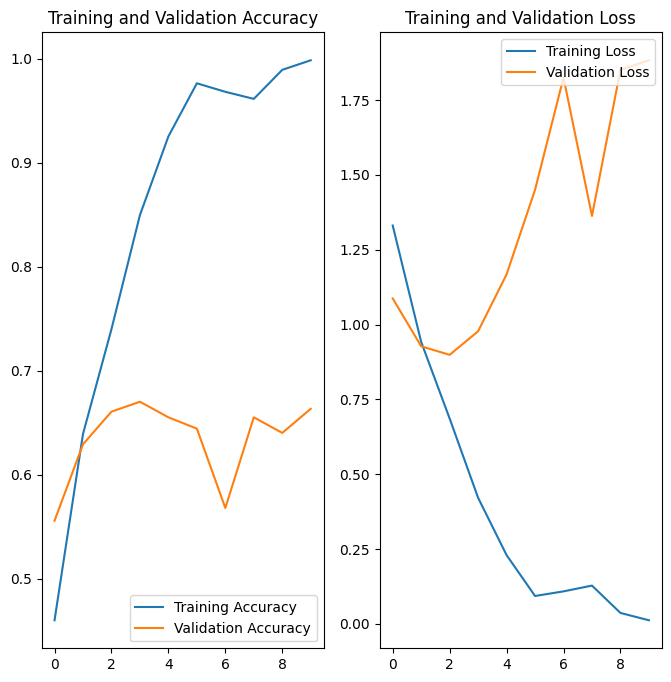

In [65]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

图表显示，训练准确率和验证准确率相差很大，并且模型在验证集上仅达到了 60% 左右的准确率。

以下教程部分展示了如何检查出了什么问题并尝试提高模型的整体性能。

## 过拟合

在上面的图表中，训练准确率随时间呈线性提升，而验证准确率在训练过程中停滞在 60% 左右。同时，训练准确率和验证准确率之间的差异也很明显，这是[过拟合](https://tensorflow.google.cn/tutorials/keras/overfit_and_underfit)的标志。

当训练样本数量较少时，模型有时会从训练样本中的噪声或不需要的细节中学习，以至于对模型在新样本上的性能产生负面影响。这种现象被称为过拟合。这意味着模型将很难在新数据集上泛化。

在训练过程中有多种方式解决过拟合问题。在本教程中，您将使用*数据增强*并将*随机失活*添加到模型中。

## 数据增强

过拟合通常会在训练样本数量较少的情况下发生。[数据增强](./data_augmentation.ipynb)采用的方法是：通过增强然后使用随机转换，从现有样本中生成其他训练数据，产生看起来可信的图像。这有助于向模型公开数据的更多方面，且有助于更好地进行泛化。

您将使用以下 Keras 预处理层实现数据增强：`tf.keras.layers.RandomFlip`、 `tf.keras.layers.RandomRotation` 和 `tf.keras.layers.RandomZoom`。这些层可以像其他层一样包含在您的模型中，并在 GPU 上运行。

In [66]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

通过对同一图像多次应用数据增强来呈现一些增强示例：

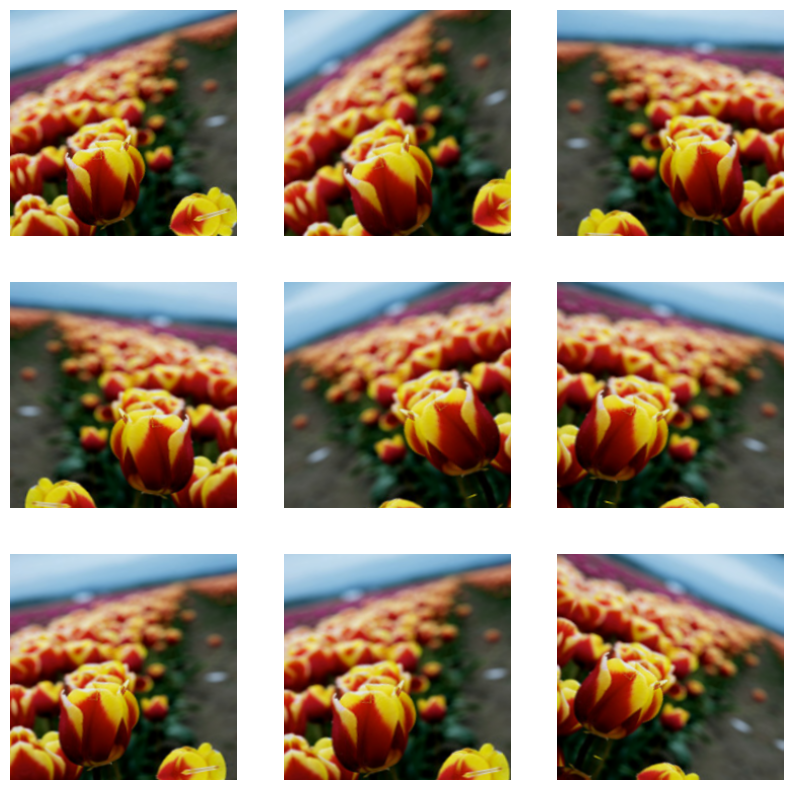

In [67]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

在下一步训练之前，您将在模型中添加数据增强。

## 随机失活

另一种减少过拟合的技术是向网络中引入[随机失活](https://developers.google.com/machine-learning/glossary#dropout_regularization){:.external}正则化。

将随机失活应用于层时，它会在训练过程中随机从该层丢弃（通过将激活设置为零）一些输出单元。随机失活会接受小数作为输入值，形式如 0.1、0.2、0.4 等。这意味着从应用了随机失活的层中随机丢弃 10%、20% 或 40% 的输出单元。

在使用增强图像对其进行训练之前，我们来使用 `tf.keras.layers.Dropout` 创建一个新的神经网络：

In [68]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax', name="outputs")
])

## 编译并训练模型

In [69]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [70]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling_5 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 112, 112, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 56, 56, 32)        0         
 ng2D)                                                

 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         


 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       


 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 16)        0         


 g2D)                                                            


 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      


 max_pooling2d_4 (MaxPoolin  (None, 45, 45, 32)        0         


 g2D)                                                            


 conv2d_5 (Conv2D)           (None, 45, 45, 64)        18496     


 max_pooling2d_5 (MaxPoolin  (None, 22, 22, 64)        0         


 g2D)                                                            


 dropout (Dropout)           (None, 22, 22, 64)        0         


 flatten_1 (Flatten)         (None, 30976)             0         


 dense_2 (Dense)             (None, 128)               3965056   


 outputs (Dense)             (None, 5)                 645       


Total params: 3989285 (15.22 MB)


Trainable params: 3989285 (15.22 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [71]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2025-08-29 08:16:43.984385: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_5/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


92/92 [==============================] - 3s 18ms/step - loss: 1.3332 - accuracy: 0.4404 - val_loss: 1.1132 - val_accuracy: 0.5518
Epoch 2/15
92/92 [==============================] - 1s 16ms/step - loss: 1.0216 - accuracy: 0.5916 - val_loss: 0.9661 - val_accuracy: 0.6240
Epoch 3/15
92/92 [==============================] - 1s 16ms/step - loss: 0.9228 - accuracy: 0.6379 - val_loss: 0.9188 - val_accuracy: 0.6213
Epoch 4/15
92/92 [==============================] - 1s 16ms/step - loss: 0.8385 - accuracy: 0.6809 - val_loss: 0.8109 - val_accuracy: 0.6703
Epoch 5/15
92/92 [==============================] - 1s 16ms/step - loss: 0.7952 - accuracy: 0.6877 - val_loss: 0.8204 - val_accuracy: 0.6621
Epoch 6/15
92/92 [==============================] - 1s 16ms/step - loss: 0.7623 - accuracy: 0.7050 - val_loss: 0.8325 - val_accuracy: 0.6975
Epoch 7/15
92/92 [==============================] - 1s 16ms/step - loss: 0.7211 - accuracy: 0.7268 - val_loss: 0.8667 - val_accuracy: 0.6621
Epoch 8/15
92/92 [======

13/92 [===>..........................] - ETA: 2s - loss: 1.8213 - accuracy: 0.2475

15/92 [===>..........................] - ETA: 2s - loss: 1.7746 - accuracy: 0.2585

17/92 [====>.........................] - ETA: 2s - loss: 1.7351 - accuracy: 0.2743

19/92 [=====>........................] - ETA: 2s - loss: 1.7001 - accuracy: 0.2783

21/92 [=====>........................] - ETA: 2s - loss: 1.6724 - accuracy: 0.2967

23/92 [======>.......................] - ETA: 2s - loss: 1.6493 - accuracy: 0.3022

25/92 [=======>......................] - ETA: 2s - loss: 1.6145 - accuracy: 0.3207

27/92 [=======>......................] - ETA: 1s - loss: 1.5908 - accuracy: 0.3201

29/92 [========>.....................] - ETA: 1s - loss: 1.5766 - accuracy: 0.3315

31/92 [=========>....................] - ETA: 1s - loss: 1.5660 - accuracy: 0.3333

33/92 [=========>....................] - ETA: 1s - loss: 1.5529 - accuracy: 0.3349

35/92 [==========>...................] - ETA: 1s - loss: 1.5444 - accuracy: 0.3363

37/92 [===========>..................] - ETA: 1s - loss: 1.5348 - accuracy: 0.3367

39/92 [===========>..................] - ETA: 1s - loss: 1.5241 - accuracy: 0.3395

41/92 [============>.................] - ETA: 1s - loss: 1.5121 - accuracy: 0.3451

43/92 [=============>................] - ETA: 1s - loss: 1.5010 - accuracy: 0.3458

45/92 [=============>................] - ETA: 1s - loss: 1.4921 - accuracy: 0.3471

47/92 [==============>...............] - ETA: 1s - loss: 1.4824 - accuracy: 0.3509

49/92 [==============>...............] - ETA: 1s - loss: 1.4701 - accuracy: 0.3571

51/92 [===============>..............] - ETA: 1s - loss: 1.4609 - accuracy: 0.3615

53/92 [================>.............] - ETA: 1s - loss: 1.4527 - accuracy: 0.3632

55/92 [================>.............] - ETA: 1s - loss: 1.4408 - accuracy: 0.3699

57/92 [=================>............] - ETA: 0s - loss: 1.4348 - accuracy: 0.3717

59/92 [==================>...........] - ETA: 0s - loss: 1.4299 - accuracy: 0.3739

61/92 [==================>...........] - ETA: 0s - loss: 1.4247 - accuracy: 0.3786

63/92 [===================>..........] - ETA: 0s - loss: 1.4167 - accuracy: 0.3810

65/92 [====================>.........] - ETA: 0s - loss: 1.4134 - accuracy: 0.3832

67/92 [====================>.........] - ETA: 0s - loss: 1.4119 - accuracy: 0.3830

69/92 [=====================>........] - ETA: 0s - loss: 1.4062 - accuracy: 0.3841

71/92 [======================>.......] - ETA: 0s - loss: 1.4021 - accuracy: 0.3860

73/92 [======================>.......] - ETA: 0s - loss: 1.3954 - accuracy: 0.3875

75/92 [=======================>......] - ETA: 0s - loss: 1.3932 - accuracy: 0.3896

77/92 [========================>.....] - ETA: 0s - loss: 1.3888 - accuracy: 0.3921

79/92 [========================>.....] - ETA: 0s - loss: 1.3864 - accuracy: 0.3944

81/92 [=========================>....] - ETA: 0s - loss: 1.3804 - accuracy: 0.3986

83/92 [==========================>...] - ETA: 0s - loss: 1.3737 - accuracy: 0.4007

85/92 [==========================>...] - ETA: 0s - loss: 1.3681 - accuracy: 0.4030

87/92 [===========================>..] - ETA: 0s - loss: 1.3609 - accuracy: 0.4053

89/92 [============================>.] - ETA: 0s - loss: 1.3536 - accuracy: 0.4102

91/92 [============================>.] - ETA: 0s - loss: 1.3521 - accuracy: 0.4098

92/92 [==============================] - 6s 32ms/step - loss: 1.3535 - accuracy: 0.4084 - val_loss: 1.0961 - val_accuracy: 0.5381


Epoch 2/15


 1/92 [..............................] - ETA: 2s - loss: 1.1497 - accuracy: 0.5938

 3/92 [..............................] - ETA: 2s - loss: 1.2416 - accuracy: 0.4583

 5/92 [>.............................] - ETA: 2s - loss: 1.1877 - accuracy: 0.4750

 7/92 [=>............................] - ETA: 2s - loss: 1.1953 - accuracy: 0.4688

 9/92 [=>............................] - ETA: 2s - loss: 1.2034 - accuracy: 0.4583

11/92 [==>...........................] - ETA: 2s - loss: 1.1996 - accuracy: 0.4631

13/92 [===>..........................] - ETA: 2s - loss: 1.2070 - accuracy: 0.4904

15/92 [===>..........................] - ETA: 2s - loss: 1.2119 - accuracy: 0.5021

17/92 [====>.........................] - ETA: 1s - loss: 1.2227 - accuracy: 0.5037

19/92 [=====>........................] - ETA: 1s - loss: 1.2064 - accuracy: 0.5148

21/92 [=====>........................] - ETA: 1s - loss: 1.2038 - accuracy: 0.5134

23/92 [======>.......................] - ETA: 1s - loss: 1.1969 - accuracy: 0.5163

25/92 [=======>......................] - ETA: 1s - loss: 1.1918 - accuracy: 0.5163

27/92 [=======>......................] - ETA: 1s - loss: 1.1748 - accuracy: 0.5197

29/92 [========>.....................] - ETA: 1s - loss: 1.1768 - accuracy: 0.5162

31/92 [=========>....................] - ETA: 1s - loss: 1.1696 - accuracy: 0.5192

33/92 [=========>....................] - ETA: 1s - loss: 1.1727 - accuracy: 0.5161

35/92 [==========>...................] - ETA: 1s - loss: 1.1607 - accuracy: 0.5170

37/92 [===========>..................] - ETA: 1s - loss: 1.1558 - accuracy: 0.5169

39/92 [===========>..................] - ETA: 1s - loss: 1.1524 - accuracy: 0.5160

41/92 [============>.................] - ETA: 1s - loss: 1.1470 - accuracy: 0.5213

43/92 [=============>................] - ETA: 1s - loss: 1.1437 - accuracy: 0.5189

45/92 [=============>................] - ETA: 1s - loss: 1.1441 - accuracy: 0.5201

47/92 [==============>...............] - ETA: 1s - loss: 1.1454 - accuracy: 0.5166

49/92 [==============>...............] - ETA: 1s - loss: 1.1408 - accuracy: 0.5191

51/92 [===============>..............] - ETA: 1s - loss: 1.1422 - accuracy: 0.5221

53/92 [================>.............] - ETA: 1s - loss: 1.1386 - accuracy: 0.5248

55/92 [================>.............] - ETA: 0s - loss: 1.1386 - accuracy: 0.5233

57/92 [=================>............] - ETA: 0s - loss: 1.1378 - accuracy: 0.5225

59/92 [==================>...........] - ETA: 0s - loss: 1.1331 - accuracy: 0.5254

61/92 [==================>...........] - ETA: 0s - loss: 1.1273 - accuracy: 0.5256

63/92 [===================>..........] - ETA: 0s - loss: 1.1278 - accuracy: 0.5273

65/92 [====================>.........] - ETA: 0s - loss: 1.1239 - accuracy: 0.5308

67/92 [====================>.........] - ETA: 0s - loss: 1.1237 - accuracy: 0.5312

69/92 [=====================>........] - ETA: 0s - loss: 1.1226 - accuracy: 0.5349

71/92 [======================>.......] - ETA: 0s - loss: 1.1195 - accuracy: 0.5370

73/92 [======================>.......] - ETA: 0s - loss: 1.1161 - accuracy: 0.5398

75/92 [=======================>......] - ETA: 0s - loss: 1.1132 - accuracy: 0.5412

77/92 [========================>.....] - ETA: 0s - loss: 1.1111 - accuracy: 0.5418

79/92 [========================>.....] - ETA: 0s - loss: 1.1062 - accuracy: 0.5443

82/92 [=========================>....] - ETA: 0s - loss: 1.1059 - accuracy: 0.5466

84/92 [==========================>...] - ETA: 0s - loss: 1.1091 - accuracy: 0.5451

86/92 [===========================>..] - ETA: 0s - loss: 1.1067 - accuracy: 0.5466

88/92 [===========================>..] - ETA: 0s - loss: 1.1021 - accuracy: 0.5481

90/92 [============================>.] - ETA: 0s - loss: 1.0972 - accuracy: 0.5494

92/92 [==============================] - ETA: 0s - loss: 1.0937 - accuracy: 0.5518

92/92 [==============================] - 3s 29ms/step - loss: 1.0937 - accuracy: 0.5518 - val_loss: 1.0004 - val_accuracy: 0.6076


Epoch 3/15


 1/92 [..............................] - ETA: 2s - loss: 1.0835 - accuracy: 0.5000

 3/92 [..............................] - ETA: 2s - loss: 0.9127 - accuracy: 0.6250

 5/92 [>.............................] - ETA: 2s - loss: 1.0423 - accuracy: 0.5562

 7/92 [=>............................] - ETA: 2s - loss: 0.9967 - accuracy: 0.5759

10/92 [==>...........................] - ETA: 2s - loss: 0.9768 - accuracy: 0.5897

12/92 [==>...........................] - ETA: 2s - loss: 0.9556 - accuracy: 0.6037

14/92 [===>..........................] - ETA: 2s - loss: 0.9470 - accuracy: 0.5886

16/92 [====>.........................] - ETA: 2s - loss: 0.9704 - accuracy: 0.5933

18/92 [====>.........................] - ETA: 1s - loss: 0.9765 - accuracy: 0.6056

20/92 [=====>........................] - ETA: 1s - loss: 0.9658 - accuracy: 0.6108

22/92 [======>.......................] - ETA: 1s - loss: 0.9547 - accuracy: 0.6149

24/92 [======>.......................] - ETA: 1s - loss: 0.9559 - accuracy: 0.6132

26/92 [=======>......................] - ETA: 1s - loss: 0.9548 - accuracy: 0.6177

28/92 [========>.....................] - ETA: 1s - loss: 0.9618 - accuracy: 0.6137

30/92 [========>.....................] - ETA: 1s - loss: 0.9687 - accuracy: 0.6187

32/92 [=========>....................] - ETA: 1s - loss: 0.9847 - accuracy: 0.6033

34/92 [==========>...................] - ETA: 1s - loss: 0.9823 - accuracy: 0.6056

36/92 [==========>...................] - ETA: 1s - loss: 0.9830 - accuracy: 0.6093

38/92 [===========>..................] - ETA: 1s - loss: 0.9844 - accuracy: 0.6101

40/92 [============>.................] - ETA: 1s - loss: 0.9837 - accuracy: 0.6101

42/92 [============>.................] - ETA: 1s - loss: 0.9842 - accuracy: 0.6070

44/92 [=============>................] - ETA: 1s - loss: 0.9888 - accuracy: 0.6036

46/92 [==============>...............] - ETA: 1s - loss: 0.9892 - accuracy: 0.6045

48/92 [==============>...............] - ETA: 1s - loss: 0.9909 - accuracy: 0.6054

50/92 [===============>..............] - ETA: 1s - loss: 0.9933 - accuracy: 0.6043

52/92 [===============>..............] - ETA: 1s - loss: 0.9941 - accuracy: 0.6057

54/92 [================>.............] - ETA: 1s - loss: 0.9929 - accuracy: 0.6047

56/92 [=================>............] - ETA: 0s - loss: 0.9907 - accuracy: 0.6031

58/92 [=================>............] - ETA: 0s - loss: 0.9893 - accuracy: 0.6023

60/92 [==================>...........] - ETA: 0s - loss: 0.9915 - accuracy: 0.6020

62/92 [===================>..........] - ETA: 0s - loss: 0.9882 - accuracy: 0.6053

64/92 [===================>..........] - ETA: 0s - loss: 0.9916 - accuracy: 0.6039

66/92 [====================>.........] - ETA: 0s - loss: 0.9937 - accuracy: 0.6046

68/92 [=====================>........] - ETA: 0s - loss: 0.9908 - accuracy: 0.6056

70/92 [=====================>........] - ETA: 0s - loss: 0.9886 - accuracy: 0.6066

72/92 [======================>.......] - ETA: 0s - loss: 0.9887 - accuracy: 0.6067

74/92 [=======================>......] - ETA: 0s - loss: 0.9915 - accuracy: 0.6059

76/92 [=======================>......] - ETA: 0s - loss: 0.9920 - accuracy: 0.6048

78/92 [========================>.....] - ETA: 0s - loss: 0.9896 - accuracy: 0.6057

80/92 [=========================>....] - ETA: 0s - loss: 0.9892 - accuracy: 0.6058

82/92 [=========================>....] - ETA: 0s - loss: 0.9866 - accuracy: 0.6067

84/92 [==========================>...] - ETA: 0s - loss: 0.9858 - accuracy: 0.6082

86/92 [===========================>..] - ETA: 0s - loss: 0.9845 - accuracy: 0.6090

88/92 [===========================>..] - ETA: 0s - loss: 0.9818 - accuracy: 0.6111

90/92 [============================>.] - ETA: 0s - loss: 0.9831 - accuracy: 0.6107

92/92 [==============================] - ETA: 0s - loss: 0.9790 - accuracy: 0.6117

92/92 [==============================] - 3s 29ms/step - loss: 0.9790 - accuracy: 0.6117 - val_loss: 0.9760 - val_accuracy: 0.6076


Epoch 4/15


 1/92 [..............................] - ETA: 2s - loss: 0.9009 - accuracy: 0.6250

 3/92 [..............................] - ETA: 2s - loss: 0.9643 - accuracy: 0.6146

 5/92 [>.............................] - ETA: 2s - loss: 1.0081 - accuracy: 0.5813

 7/92 [=>............................] - ETA: 2s - loss: 1.0560 - accuracy: 0.5536

 9/92 [=>............................] - ETA: 2s - loss: 0.9954 - accuracy: 0.5903

11/92 [==>...........................] - ETA: 2s - loss: 0.9690 - accuracy: 0.5966

13/92 [===>..........................] - ETA: 2s - loss: 0.9490 - accuracy: 0.6106

15/92 [===>..........................] - ETA: 2s - loss: 0.9349 - accuracy: 0.6250

17/92 [====>.........................] - ETA: 2s - loss: 0.9216 - accuracy: 0.6379

19/92 [=====>........................] - ETA: 1s - loss: 0.9228 - accuracy: 0.6365

21/92 [=====>........................] - ETA: 1s - loss: 0.9182 - accuracy: 0.6384

23/92 [======>.......................] - ETA: 1s - loss: 0.9085 - accuracy: 0.6372

25/92 [=======>......................] - ETA: 1s - loss: 0.9209 - accuracy: 0.6400

27/92 [=======>......................] - ETA: 1s - loss: 0.9040 - accuracy: 0.6493

29/92 [========>.....................] - ETA: 1s - loss: 0.8927 - accuracy: 0.6606

31/92 [=========>....................] - ETA: 1s - loss: 0.9072 - accuracy: 0.6583

33/92 [=========>....................] - ETA: 1s - loss: 0.9050 - accuracy: 0.6581

35/92 [==========>...................] - ETA: 1s - loss: 0.9130 - accuracy: 0.6554

37/92 [===========>..................] - ETA: 1s - loss: 0.9084 - accuracy: 0.6554

39/92 [===========>..................] - ETA: 1s - loss: 0.9121 - accuracy: 0.6554

41/92 [============>.................] - ETA: 1s - loss: 0.9217 - accuracy: 0.6502

43/92 [=============>................] - ETA: 1s - loss: 0.9216 - accuracy: 0.6475

45/92 [=============>................] - ETA: 1s - loss: 0.9219 - accuracy: 0.6424

47/92 [==============>...............] - ETA: 1s - loss: 0.9229 - accuracy: 0.6416

49/92 [==============>...............] - ETA: 1s - loss: 0.9260 - accuracy: 0.6416

51/92 [===============>..............] - ETA: 1s - loss: 0.9231 - accuracy: 0.6434

53/92 [================>.............] - ETA: 1s - loss: 0.9218 - accuracy: 0.6456

55/92 [================>.............] - ETA: 0s - loss: 0.9139 - accuracy: 0.6477

57/92 [=================>............] - ETA: 0s - loss: 0.9198 - accuracy: 0.6420

59/92 [==================>...........] - ETA: 0s - loss: 0.9173 - accuracy: 0.6441

61/92 [==================>...........] - ETA: 0s - loss: 0.9139 - accuracy: 0.6455

63/92 [===================>..........] - ETA: 0s - loss: 0.9118 - accuracy: 0.6458

66/92 [====================>.........] - ETA: 0s - loss: 0.9108 - accuracy: 0.6473

68/92 [=====================>........] - ETA: 0s - loss: 0.9085 - accuracy: 0.6485

70/92 [=====================>........] - ETA: 0s - loss: 0.9092 - accuracy: 0.6487

72/92 [======================>.......] - ETA: 0s - loss: 0.9100 - accuracy: 0.6472

74/92 [=======================>......] - ETA: 0s - loss: 0.9129 - accuracy: 0.6462

76/92 [=======================>......] - ETA: 0s - loss: 0.9101 - accuracy: 0.6481

78/92 [========================>.....] - ETA: 0s - loss: 0.9115 - accuracy: 0.6463

80/92 [=========================>....] - ETA: 0s - loss: 0.9061 - accuracy: 0.6481

82/92 [=========================>....] - ETA: 0s - loss: 0.9045 - accuracy: 0.6487

84/92 [==========================>...] - ETA: 0s - loss: 0.9024 - accuracy: 0.6496

86/92 [===========================>..] - ETA: 0s - loss: 0.9006 - accuracy: 0.6509

88/92 [===========================>..] - ETA: 0s - loss: 0.8960 - accuracy: 0.6531

90/92 [============================>.] - ETA: 0s - loss: 0.8954 - accuracy: 0.6532

92/92 [==============================] - ETA: 0s - loss: 0.8971 - accuracy: 0.6529

92/92 [==============================] - 3s 29ms/step - loss: 0.8971 - accuracy: 0.6529 - val_loss: 0.8705 - val_accuracy: 0.6540


Epoch 5/15


 1/92 [..............................] - ETA: 2s - loss: 0.8263 - accuracy: 0.6562

 3/92 [..............................] - ETA: 2s - loss: 0.8784 - accuracy: 0.6771

 5/92 [>.............................] - ETA: 2s - loss: 0.8495 - accuracy: 0.6812

 7/92 [=>............................] - ETA: 2s - loss: 0.8759 - accuracy: 0.6786

 9/92 [=>............................] - ETA: 2s - loss: 0.8800 - accuracy: 0.6701

11/92 [==>...........................] - ETA: 2s - loss: 0.8589 - accuracy: 0.6761

13/92 [===>..........................] - ETA: 2s - loss: 0.8710 - accuracy: 0.6779

15/92 [===>..........................] - ETA: 2s - loss: 0.8738 - accuracy: 0.6750

17/92 [====>.........................] - ETA: 1s - loss: 0.8585 - accuracy: 0.6783

19/92 [=====>........................] - ETA: 1s - loss: 0.8388 - accuracy: 0.6859

21/92 [=====>........................] - ETA: 1s - loss: 0.8418 - accuracy: 0.6830

23/92 [======>.......................] - ETA: 1s - loss: 0.8575 - accuracy: 0.6753

25/92 [=======>......................] - ETA: 1s - loss: 0.8503 - accuracy: 0.6800

27/92 [=======>......................] - ETA: 1s - loss: 0.8521 - accuracy: 0.6829

29/92 [========>.....................] - ETA: 1s - loss: 0.8442 - accuracy: 0.6853

31/92 [=========>....................] - ETA: 1s - loss: 0.8383 - accuracy: 0.6875

33/92 [=========>....................] - ETA: 1s - loss: 0.8385 - accuracy: 0.6903

35/92 [==========>...................] - ETA: 1s - loss: 0.8454 - accuracy: 0.6830

37/92 [===========>..................] - ETA: 1s - loss: 0.8450 - accuracy: 0.6807

39/92 [===========>..................] - ETA: 1s - loss: 0.8397 - accuracy: 0.6859

41/92 [============>.................] - ETA: 1s - loss: 0.8456 - accuracy: 0.6837

43/92 [=============>................] - ETA: 1s - loss: 0.8407 - accuracy: 0.6846

45/92 [=============>................] - ETA: 1s - loss: 0.8422 - accuracy: 0.6833

47/92 [==============>...............] - ETA: 1s - loss: 0.8436 - accuracy: 0.6828

49/92 [==============>...............] - ETA: 1s - loss: 0.8387 - accuracy: 0.6837

51/92 [===============>..............] - ETA: 1s - loss: 0.8434 - accuracy: 0.6801

53/92 [================>.............] - ETA: 1s - loss: 0.8461 - accuracy: 0.6792

55/92 [================>.............] - ETA: 0s - loss: 0.8431 - accuracy: 0.6784

57/92 [=================>............] - ETA: 0s - loss: 0.8437 - accuracy: 0.6804

59/92 [==================>...........] - ETA: 0s - loss: 0.8447 - accuracy: 0.6801

61/92 [==================>...........] - ETA: 0s - loss: 0.8470 - accuracy: 0.6778

63/92 [===================>..........] - ETA: 0s - loss: 0.8445 - accuracy: 0.6781

65/92 [====================>.........] - ETA: 0s - loss: 0.8423 - accuracy: 0.6779

67/92 [====================>.........] - ETA: 0s - loss: 0.8506 - accuracy: 0.6763

69/92 [=====================>........] - ETA: 0s - loss: 0.8518 - accuracy: 0.6771

71/92 [======================>.......] - ETA: 0s - loss: 0.8500 - accuracy: 0.6778

73/92 [======================>.......] - ETA: 0s - loss: 0.8467 - accuracy: 0.6807

75/92 [=======================>......] - ETA: 0s - loss: 0.8420 - accuracy: 0.6821

77/92 [========================>.....] - ETA: 0s - loss: 0.8400 - accuracy: 0.6834

79/92 [========================>.....] - ETA: 0s - loss: 0.8403 - accuracy: 0.6831

81/92 [=========================>....] - ETA: 0s - loss: 0.8398 - accuracy: 0.6821

83/92 [==========================>...] - ETA: 0s - loss: 0.8340 - accuracy: 0.6849

85/92 [==========================>...] - ETA: 0s - loss: 0.8348 - accuracy: 0.6842

88/92 [===========================>..] - ETA: 0s - loss: 0.8313 - accuracy: 0.6859

90/92 [============================>.] - ETA: 0s - loss: 0.8253 - accuracy: 0.6873

92/92 [==============================] - ETA: 0s - loss: 0.8262 - accuracy: 0.6863

92/92 [==============================] - 3s 29ms/step - loss: 0.8262 - accuracy: 0.6863 - val_loss: 0.9474 - val_accuracy: 0.6335


Epoch 6/15


 1/92 [..............................] - ETA: 2s - loss: 1.1585 - accuracy: 0.5312

 3/92 [..............................] - ETA: 2s - loss: 0.9117 - accuracy: 0.6354

 6/92 [>.............................] - ETA: 2s - loss: 0.8147 - accuracy: 0.6793

 8/92 [=>............................] - ETA: 2s - loss: 0.8119 - accuracy: 0.6855

10/92 [==>...........................] - ETA: 2s - loss: 0.8329 - accuracy: 0.6731

12/92 [==>...........................] - ETA: 2s - loss: 0.8221 - accuracy: 0.6729

14/92 [===>..........................] - ETA: 2s - loss: 0.8137 - accuracy: 0.6750

16/92 [====>.........................] - ETA: 1s - loss: 0.8300 - accuracy: 0.6766

18/92 [====>.........................] - ETA: 1s - loss: 0.8264 - accuracy: 0.6778

20/92 [=====>........................] - ETA: 1s - loss: 0.8470 - accuracy: 0.6661

22/92 [======>.......................] - ETA: 1s - loss: 0.8479 - accuracy: 0.6624

24/92 [======>.......................] - ETA: 1s - loss: 0.8524 - accuracy: 0.6592

26/92 [=======>......................] - ETA: 1s - loss: 0.8395 - accuracy: 0.6663

28/92 [========>.....................] - ETA: 1s - loss: 0.8373 - accuracy: 0.6700

30/92 [========>.....................] - ETA: 1s - loss: 0.8407 - accuracy: 0.6691

32/92 [=========>....................] - ETA: 1s - loss: 0.8322 - accuracy: 0.6732

34/92 [==========>...................] - ETA: 1s - loss: 0.8292 - accuracy: 0.6750

36/92 [==========>...................] - ETA: 1s - loss: 0.8277 - accuracy: 0.6766

38/92 [===========>..................] - ETA: 1s - loss: 0.8190 - accuracy: 0.6796

40/92 [============>.................] - ETA: 1s - loss: 0.8156 - accuracy: 0.6816

42/92 [============>.................] - ETA: 1s - loss: 0.8160 - accuracy: 0.6841

44/92 [=============>................] - ETA: 1s - loss: 0.8116 - accuracy: 0.6829

46/92 [==============>...............] - ETA: 1s - loss: 0.8129 - accuracy: 0.6851

48/92 [==============>...............] - ETA: 1s - loss: 0.8155 - accuracy: 0.6885

50/92 [===============>..............] - ETA: 1s - loss: 0.8095 - accuracy: 0.6916

52/92 [===============>..............] - ETA: 1s - loss: 0.8076 - accuracy: 0.6926

54/92 [================>.............] - ETA: 1s - loss: 0.8019 - accuracy: 0.6959

56/92 [=================>............] - ETA: 0s - loss: 0.8001 - accuracy: 0.6945

58/92 [=================>............] - ETA: 0s - loss: 0.7966 - accuracy: 0.6959

60/92 [==================>...........] - ETA: 0s - loss: 0.7938 - accuracy: 0.6977

62/92 [===================>..........] - ETA: 0s - loss: 0.7896 - accuracy: 0.6984

64/92 [===================>..........] - ETA: 0s - loss: 0.7837 - accuracy: 0.7000

66/92 [====================>.........] - ETA: 0s - loss: 0.7865 - accuracy: 0.6991

68/92 [=====================>........] - ETA: 0s - loss: 0.7832 - accuracy: 0.7016

70/92 [=====================>........] - ETA: 0s - loss: 0.7829 - accuracy: 0.7025

72/92 [======================>.......] - ETA: 0s - loss: 0.7888 - accuracy: 0.7003

74/92 [=======================>......] - ETA: 0s - loss: 0.7950 - accuracy: 0.6983

76/92 [=======================>......] - ETA: 0s - loss: 0.7937 - accuracy: 0.6993

78/92 [========================>.....] - ETA: 0s - loss: 0.7953 - accuracy: 0.6994

80/92 [=========================>....] - ETA: 0s - loss: 0.7955 - accuracy: 0.6998

82/92 [=========================>....] - ETA: 0s - loss: 0.7973 - accuracy: 0.6995

84/92 [==========================>...] - ETA: 0s - loss: 0.7973 - accuracy: 0.6996

86/92 [===========================>..] - ETA: 0s - loss: 0.7997 - accuracy: 0.6993

88/92 [===========================>..] - ETA: 0s - loss: 0.7968 - accuracy: 0.7009

90/92 [============================>.] - ETA: 0s - loss: 0.7947 - accuracy: 0.7013

92/92 [==============================] - ETA: 0s - loss: 0.7942 - accuracy: 0.7006

92/92 [==============================] - 3s 29ms/step - loss: 0.7942 - accuracy: 0.7006 - val_loss: 0.9650 - val_accuracy: 0.6322


Epoch 7/15


 1/92 [..............................] - ETA: 2s - loss: 0.8877 - accuracy: 0.7812

 3/92 [..............................] - ETA: 2s - loss: 0.8092 - accuracy: 0.7083

 5/92 [>.............................] - ETA: 2s - loss: 0.7368 - accuracy: 0.7375

 7/92 [=>............................] - ETA: 2s - loss: 0.7050 - accuracy: 0.7321

10/92 [==>...........................] - ETA: 2s - loss: 0.6979 - accuracy: 0.7276

12/92 [==>...........................] - ETA: 2s - loss: 0.7223 - accuracy: 0.7234

14/92 [===>..........................] - ETA: 2s - loss: 0.6957 - accuracy: 0.7318

16/92 [====>.........................] - ETA: 1s - loss: 0.7146 - accuracy: 0.7242

18/92 [====>.........................] - ETA: 1s - loss: 0.7093 - accuracy: 0.7236

20/92 [=====>........................] - ETA: 1s - loss: 0.7116 - accuracy: 0.7199

22/92 [======>.......................] - ETA: 1s - loss: 0.7189 - accuracy: 0.7170

24/92 [======>.......................] - ETA: 1s - loss: 0.7238 - accuracy: 0.7132

26/92 [=======>......................] - ETA: 1s - loss: 0.7296 - accuracy: 0.7124

28/92 [========>.....................] - ETA: 1s - loss: 0.7339 - accuracy: 0.7106

30/92 [========>.....................] - ETA: 1s - loss: 0.7242 - accuracy: 0.7164

32/92 [=========>....................] - ETA: 1s - loss: 0.7235 - accuracy: 0.7175

34/92 [==========>...................] - ETA: 1s - loss: 0.7208 - accuracy: 0.7185

36/92 [==========>...................] - ETA: 1s - loss: 0.7189 - accuracy: 0.7212

38/92 [===========>..................] - ETA: 1s - loss: 0.7249 - accuracy: 0.7185

40/92 [============>.................] - ETA: 1s - loss: 0.7254 - accuracy: 0.7178

42/92 [============>.................] - ETA: 1s - loss: 0.7258 - accuracy: 0.7156

44/92 [=============>................] - ETA: 1s - loss: 0.7272 - accuracy: 0.7129

46/92 [==============>...............] - ETA: 1s - loss: 0.7251 - accuracy: 0.7145

48/92 [==============>...............] - ETA: 1s - loss: 0.7286 - accuracy: 0.7140

50/92 [===============>..............] - ETA: 1s - loss: 0.7400 - accuracy: 0.7085

52/92 [===============>..............] - ETA: 1s - loss: 0.7411 - accuracy: 0.7077

54/92 [================>.............] - ETA: 1s - loss: 0.7494 - accuracy: 0.7006

56/92 [=================>............] - ETA: 0s - loss: 0.7492 - accuracy: 0.6996

58/92 [=================>............] - ETA: 0s - loss: 0.7475 - accuracy: 0.7018

60/92 [==================>...........] - ETA: 0s - loss: 0.7459 - accuracy: 0.7050

62/92 [===================>..........] - ETA: 0s - loss: 0.7458 - accuracy: 0.7075

64/92 [===================>..........] - ETA: 0s - loss: 0.7455 - accuracy: 0.7078

66/92 [====================>.........] - ETA: 0s - loss: 0.7458 - accuracy: 0.7082

68/92 [=====================>........] - ETA: 0s - loss: 0.7435 - accuracy: 0.7108

70/92 [=====================>........] - ETA: 0s - loss: 0.7455 - accuracy: 0.7101

72/92 [======================>.......] - ETA: 0s - loss: 0.7475 - accuracy: 0.7091

74/92 [=======================>......] - ETA: 0s - loss: 0.7456 - accuracy: 0.7085

76/92 [=======================>......] - ETA: 0s - loss: 0.7451 - accuracy: 0.7079

78/92 [========================>.....] - ETA: 0s - loss: 0.7463 - accuracy: 0.7082

80/92 [=========================>....] - ETA: 0s - loss: 0.7482 - accuracy: 0.7065

82/92 [=========================>....] - ETA: 0s - loss: 0.7492 - accuracy: 0.7064

84/92 [==========================>...] - ETA: 0s - loss: 0.7476 - accuracy: 0.7075

86/92 [===========================>..] - ETA: 0s - loss: 0.7442 - accuracy: 0.7095

88/92 [===========================>..] - ETA: 0s - loss: 0.7406 - accuracy: 0.7112

90/92 [============================>.] - ETA: 0s - loss: 0.7416 - accuracy: 0.7110

92/92 [==============================] - ETA: 0s - loss: 0.7456 - accuracy: 0.7101

92/92 [==============================] - 3s 29ms/step - loss: 0.7456 - accuracy: 0.7101 - val_loss: 0.7740 - val_accuracy: 0.6894


Epoch 8/15


 1/92 [..............................] - ETA: 2s - loss: 0.5273 - accuracy: 0.7812

 3/92 [..............................] - ETA: 2s - loss: 0.7278 - accuracy: 0.7188

 5/92 [>.............................] - ETA: 2s - loss: 0.6851 - accuracy: 0.7188

 7/92 [=>............................] - ETA: 2s - loss: 0.7188 - accuracy: 0.7009

 9/92 [=>............................] - ETA: 2s - loss: 0.7250 - accuracy: 0.7014

11/92 [==>...........................] - ETA: 2s - loss: 0.6930 - accuracy: 0.7131

13/92 [===>..........................] - ETA: 2s - loss: 0.6958 - accuracy: 0.7163

15/92 [===>..........................] - ETA: 2s - loss: 0.6738 - accuracy: 0.7250

17/92 [====>.........................] - ETA: 2s - loss: 0.6809 - accuracy: 0.7261

19/92 [=====>........................] - ETA: 1s - loss: 0.6913 - accuracy: 0.7253

21/92 [=====>........................] - ETA: 1s - loss: 0.6934 - accuracy: 0.7307

23/92 [======>.......................] - ETA: 1s - loss: 0.6919 - accuracy: 0.7351

25/92 [=======>......................] - ETA: 1s - loss: 0.6969 - accuracy: 0.7337

27/92 [=======>......................] - ETA: 1s - loss: 0.6951 - accuracy: 0.7350

29/92 [========>.....................] - ETA: 1s - loss: 0.6889 - accuracy: 0.7371

31/92 [=========>....................] - ETA: 1s - loss: 0.6880 - accuracy: 0.7419

33/92 [=========>....................] - ETA: 1s - loss: 0.6796 - accuracy: 0.7462

35/92 [==========>...................] - ETA: 1s - loss: 0.6741 - accuracy: 0.7482

37/92 [===========>..................] - ETA: 1s - loss: 0.6771 - accuracy: 0.7492

39/92 [===========>..................] - ETA: 1s - loss: 0.6765 - accuracy: 0.7508

41/92 [============>.................] - ETA: 1s - loss: 0.6793 - accuracy: 0.7485

43/92 [=============>................] - ETA: 1s - loss: 0.6801 - accuracy: 0.7471

45/92 [=============>................] - ETA: 1s - loss: 0.6773 - accuracy: 0.7493

47/92 [==============>...............] - ETA: 1s - loss: 0.6777 - accuracy: 0.7487

49/92 [==============>...............] - ETA: 1s - loss: 0.6851 - accuracy: 0.7455

51/92 [===============>..............] - ETA: 1s - loss: 0.6851 - accuracy: 0.7433

53/92 [================>.............] - ETA: 1s - loss: 0.6847 - accuracy: 0.7447

55/92 [================>.............] - ETA: 1s - loss: 0.6821 - accuracy: 0.7455

57/92 [=================>............] - ETA: 0s - loss: 0.6910 - accuracy: 0.7407

59/92 [==================>...........] - ETA: 0s - loss: 0.6943 - accuracy: 0.7383

61/92 [==================>...........] - ETA: 0s - loss: 0.6981 - accuracy: 0.7382

63/92 [===================>..........] - ETA: 0s - loss: 0.6978 - accuracy: 0.7381

65/92 [====================>.........] - ETA: 0s - loss: 0.6979 - accuracy: 0.7385

67/92 [====================>.........] - ETA: 0s - loss: 0.6971 - accuracy: 0.7393

69/92 [=====================>........] - ETA: 0s - loss: 0.6968 - accuracy: 0.7382

71/92 [======================>.......] - ETA: 0s - loss: 0.7018 - accuracy: 0.7350

73/92 [======================>.......] - ETA: 0s - loss: 0.7039 - accuracy: 0.7337

75/92 [=======================>......] - ETA: 0s - loss: 0.7033 - accuracy: 0.7333

77/92 [========================>.....] - ETA: 0s - loss: 0.6987 - accuracy: 0.7354

79/92 [========================>.....] - ETA: 0s - loss: 0.6988 - accuracy: 0.7366

81/92 [=========================>....] - ETA: 0s - loss: 0.6926 - accuracy: 0.7392

83/92 [==========================>...] - ETA: 0s - loss: 0.6927 - accuracy: 0.7395

85/92 [==========================>...] - ETA: 0s - loss: 0.6938 - accuracy: 0.7375

87/92 [===========================>..] - ETA: 0s - loss: 0.6966 - accuracy: 0.7356

89/92 [============================>.] - ETA: 0s - loss: 0.6979 - accuracy: 0.7349

91/92 [============================>.] - ETA: 0s - loss: 0.7007 - accuracy: 0.7342

92/92 [==============================] - 3s 29ms/step - loss: 0.7001 - accuracy: 0.7343 - val_loss: 0.7484 - val_accuracy: 0.7153


Epoch 9/15


 1/92 [..............................] - ETA: 2s - loss: 0.5842 - accuracy: 0.7812

 3/92 [..............................] - ETA: 2s - loss: 0.5817 - accuracy: 0.7917

 5/92 [>.............................] - ETA: 2s - loss: 0.6495 - accuracy: 0.7625

 8/92 [=>............................] - ETA: 2s - loss: 0.6580 - accuracy: 0.7540

10/92 [==>...........................] - ETA: 2s - loss: 0.6564 - accuracy: 0.7532

12/92 [==>...........................] - ETA: 2s - loss: 0.6509 - accuracy: 0.7633

14/92 [===>..........................] - ETA: 2s - loss: 0.6669 - accuracy: 0.7659

16/92 [====>.........................] - ETA: 1s - loss: 0.6614 - accuracy: 0.7738

18/92 [====>.........................] - ETA: 1s - loss: 0.6549 - accuracy: 0.7729

20/92 [=====>........................] - ETA: 1s - loss: 0.6636 - accuracy: 0.7722

22/92 [======>.......................] - ETA: 1s - loss: 0.6622 - accuracy: 0.7701

24/92 [======>.......................] - ETA: 1s - loss: 0.6646 - accuracy: 0.7684

26/92 [=======>......................] - ETA: 1s - loss: 0.6739 - accuracy: 0.7646

28/92 [========>.....................] - ETA: 1s - loss: 0.6732 - accuracy: 0.7613

30/92 [========>.....................] - ETA: 1s - loss: 0.6695 - accuracy: 0.7616

32/92 [=========>....................] - ETA: 1s - loss: 0.6739 - accuracy: 0.7608

34/92 [==========>...................] - ETA: 1s - loss: 0.6806 - accuracy: 0.7546

36/92 [==========>...................] - ETA: 1s - loss: 0.6769 - accuracy: 0.7561

38/92 [===========>..................] - ETA: 1s - loss: 0.6786 - accuracy: 0.7533

40/92 [============>.................] - ETA: 1s - loss: 0.6819 - accuracy: 0.7524

42/92 [============>.................] - ETA: 1s - loss: 0.6853 - accuracy: 0.7493

44/92 [=============>................] - ETA: 1s - loss: 0.6873 - accuracy: 0.7486

46/92 [==============>...............] - ETA: 1s - loss: 0.6909 - accuracy: 0.7459

48/92 [==============>...............] - ETA: 1s - loss: 0.6880 - accuracy: 0.7493

50/92 [===============>..............] - ETA: 1s - loss: 0.6863 - accuracy: 0.7481

52/92 [===============>..............] - ETA: 1s - loss: 0.6825 - accuracy: 0.7500

54/92 [================>.............] - ETA: 1s - loss: 0.6883 - accuracy: 0.7483

56/92 [=================>............] - ETA: 0s - loss: 0.6953 - accuracy: 0.7444

58/92 [=================>............] - ETA: 0s - loss: 0.6939 - accuracy: 0.7451

60/92 [==================>...........] - ETA: 0s - loss: 0.6936 - accuracy: 0.7474

62/92 [===================>..........] - ETA: 0s - loss: 0.6919 - accuracy: 0.7500

64/92 [===================>..........] - ETA: 0s - loss: 0.6943 - accuracy: 0.7500

66/92 [====================>.........] - ETA: 0s - loss: 0.6882 - accuracy: 0.7529

68/92 [=====================>........] - ETA: 0s - loss: 0.6893 - accuracy: 0.7509

70/92 [=====================>........] - ETA: 0s - loss: 0.6913 - accuracy: 0.7491

72/92 [======================>.......] - ETA: 0s - loss: 0.6935 - accuracy: 0.7470

74/92 [=======================>......] - ETA: 0s - loss: 0.6938 - accuracy: 0.7453

76/92 [=======================>......] - ETA: 0s - loss: 0.6922 - accuracy: 0.7450

78/92 [========================>.....] - ETA: 0s - loss: 0.6925 - accuracy: 0.7440

80/92 [=========================>....] - ETA: 0s - loss: 0.6928 - accuracy: 0.7449

82/92 [=========================>....] - ETA: 0s - loss: 0.6919 - accuracy: 0.7450

84/92 [==========================>...] - ETA: 0s - loss: 0.6880 - accuracy: 0.7463

86/92 [===========================>..] - ETA: 0s - loss: 0.6933 - accuracy: 0.7445

88/92 [===========================>..] - ETA: 0s - loss: 0.6906 - accuracy: 0.7439

90/92 [============================>.] - ETA: 0s - loss: 0.6925 - accuracy: 0.7430

92/92 [==============================] - ETA: 0s - loss: 0.6902 - accuracy: 0.7442

92/92 [==============================] - 3s 29ms/step - loss: 0.6902 - accuracy: 0.7442 - val_loss: 0.7523 - val_accuracy: 0.7071


Epoch 10/15


 1/92 [..............................] - ETA: 2s - loss: 0.5526 - accuracy: 0.8125

 3/92 [..............................] - ETA: 2s - loss: 0.7224 - accuracy: 0.7292

 5/92 [>.............................] - ETA: 2s - loss: 0.7717 - accuracy: 0.7312

 7/92 [=>............................] - ETA: 2s - loss: 0.7353 - accuracy: 0.7411

 9/92 [=>............................] - ETA: 2s - loss: 0.6852 - accuracy: 0.7535

11/92 [==>...........................] - ETA: 2s - loss: 0.6979 - accuracy: 0.7443

13/92 [===>..........................] - ETA: 2s - loss: 0.7147 - accuracy: 0.7332

15/92 [===>..........................] - ETA: 2s - loss: 0.7274 - accuracy: 0.7229

18/92 [====>.........................] - ETA: 1s - loss: 0.7176 - accuracy: 0.7201

20/92 [=====>........................] - ETA: 1s - loss: 0.7032 - accuracy: 0.7263

22/92 [======>.......................] - ETA: 1s - loss: 0.6913 - accuracy: 0.7385

24/92 [======>.......................] - ETA: 1s - loss: 0.6880 - accuracy: 0.7434

26/92 [=======>......................] - ETA: 1s - loss: 0.6785 - accuracy: 0.7476

28/92 [========>.....................] - ETA: 1s - loss: 0.6722 - accuracy: 0.7534

30/92 [========>.....................] - ETA: 1s - loss: 0.6685 - accuracy: 0.7542

32/92 [=========>....................] - ETA: 1s - loss: 0.6764 - accuracy: 0.7530

34/92 [==========>...................] - ETA: 1s - loss: 0.6729 - accuracy: 0.7519

36/92 [==========>...................] - ETA: 1s - loss: 0.6749 - accuracy: 0.7509

38/92 [===========>..................] - ETA: 1s - loss: 0.6700 - accuracy: 0.7517

40/92 [============>.................] - ETA: 1s - loss: 0.6722 - accuracy: 0.7516

42/92 [============>.................] - ETA: 1s - loss: 0.6696 - accuracy: 0.7515

44/92 [=============>................] - ETA: 1s - loss: 0.6608 - accuracy: 0.7564

46/92 [==============>...............] - ETA: 1s - loss: 0.6590 - accuracy: 0.7568

48/92 [==============>...............] - ETA: 1s - loss: 0.6633 - accuracy: 0.7513

50/92 [===============>..............] - ETA: 1s - loss: 0.6590 - accuracy: 0.7538

52/92 [===============>..............] - ETA: 1s - loss: 0.6594 - accuracy: 0.7554

54/92 [================>.............] - ETA: 1s - loss: 0.6538 - accuracy: 0.7581

56/92 [=================>............] - ETA: 0s - loss: 0.6521 - accuracy: 0.7578

58/92 [=================>............] - ETA: 0s - loss: 0.6600 - accuracy: 0.7543

60/92 [==================>...........] - ETA: 0s - loss: 0.6534 - accuracy: 0.7578

62/92 [===================>..........] - ETA: 0s - loss: 0.6562 - accuracy: 0.7576

64/92 [===================>..........] - ETA: 0s - loss: 0.6502 - accuracy: 0.7593

66/92 [====================>.........] - ETA: 0s - loss: 0.6490 - accuracy: 0.7600

68/92 [=====================>........] - ETA: 0s - loss: 0.6449 - accuracy: 0.7601

70/92 [=====================>........] - ETA: 0s - loss: 0.6426 - accuracy: 0.7616

72/92 [======================>.......] - ETA: 0s - loss: 0.6397 - accuracy: 0.7631

74/92 [=======================>......] - ETA: 0s - loss: 0.6381 - accuracy: 0.7640

76/92 [=======================>......] - ETA: 0s - loss: 0.6375 - accuracy: 0.7632

78/92 [========================>.....] - ETA: 0s - loss: 0.6389 - accuracy: 0.7633

80/92 [=========================>....] - ETA: 0s - loss: 0.6421 - accuracy: 0.7633

82/92 [=========================>....] - ETA: 0s - loss: 0.6443 - accuracy: 0.7634

84/92 [==========================>...] - ETA: 0s - loss: 0.6472 - accuracy: 0.7608

86/92 [===========================>..] - ETA: 0s - loss: 0.6460 - accuracy: 0.7606

88/92 [===========================>..] - ETA: 0s - loss: 0.6418 - accuracy: 0.7625

90/92 [============================>.] - ETA: 0s - loss: 0.6453 - accuracy: 0.7601

92/92 [==============================] - ETA: 0s - loss: 0.6448 - accuracy: 0.7602

92/92 [==============================] - 3s 29ms/step - loss: 0.6448 - accuracy: 0.7602 - val_loss: 0.7497 - val_accuracy: 0.7166


Epoch 11/15


 1/92 [..............................] - ETA: 2s - loss: 0.8783 - accuracy: 0.6562

 3/92 [..............................] - ETA: 2s - loss: 0.8543 - accuracy: 0.7188

 5/92 [>.............................] - ETA: 2s - loss: 0.8450 - accuracy: 0.7000

 7/92 [=>............................] - ETA: 2s - loss: 0.8161 - accuracy: 0.7098

 9/92 [=>............................] - ETA: 2s - loss: 0.7751 - accuracy: 0.7292

11/92 [==>...........................] - ETA: 2s - loss: 0.7512 - accuracy: 0.7301

13/92 [===>..........................] - ETA: 2s - loss: 0.7263 - accuracy: 0.7308

15/92 [===>..........................] - ETA: 2s - loss: 0.7156 - accuracy: 0.7375

17/92 [====>.........................] - ETA: 2s - loss: 0.7059 - accuracy: 0.7408

19/92 [=====>........................] - ETA: 1s - loss: 0.6852 - accuracy: 0.7549

21/92 [=====>........................] - ETA: 1s - loss: 0.6825 - accuracy: 0.7589

23/92 [======>.......................] - ETA: 1s - loss: 0.6761 - accuracy: 0.7609

25/92 [=======>......................] - ETA: 1s - loss: 0.6670 - accuracy: 0.7588

27/92 [=======>......................] - ETA: 1s - loss: 0.6520 - accuracy: 0.7604

29/92 [========>.....................] - ETA: 1s - loss: 0.6708 - accuracy: 0.7575

31/92 [=========>....................] - ETA: 1s - loss: 0.6560 - accuracy: 0.7621

33/92 [=========>....................] - ETA: 1s - loss: 0.6559 - accuracy: 0.7595

35/92 [==========>...................] - ETA: 1s - loss: 0.6513 - accuracy: 0.7607

37/92 [===========>..................] - ETA: 1s - loss: 0.6433 - accuracy: 0.7618

39/92 [===========>..................] - ETA: 1s - loss: 0.6448 - accuracy: 0.7620

41/92 [============>.................] - ETA: 1s - loss: 0.6474 - accuracy: 0.7614

43/92 [=============>................] - ETA: 1s - loss: 0.6505 - accuracy: 0.7573

45/92 [=============>................] - ETA: 1s - loss: 0.6499 - accuracy: 0.7576

47/92 [==============>...............] - ETA: 1s - loss: 0.6485 - accuracy: 0.7586

49/92 [==============>...............] - ETA: 1s - loss: 0.6435 - accuracy: 0.7608

51/92 [===============>..............] - ETA: 1s - loss: 0.6435 - accuracy: 0.7604

53/92 [================>.............] - ETA: 1s - loss: 0.6415 - accuracy: 0.7618

55/92 [================>.............] - ETA: 0s - loss: 0.6381 - accuracy: 0.7619

57/92 [=================>............] - ETA: 0s - loss: 0.6375 - accuracy: 0.7626

59/92 [==================>...........] - ETA: 0s - loss: 0.6334 - accuracy: 0.7654

61/92 [==================>...........] - ETA: 0s - loss: 0.6297 - accuracy: 0.7649

63/92 [===================>..........] - ETA: 0s - loss: 0.6326 - accuracy: 0.7624

65/92 [====================>.........] - ETA: 0s - loss: 0.6300 - accuracy: 0.7639

67/92 [====================>.........] - ETA: 0s - loss: 0.6278 - accuracy: 0.7631

69/92 [=====================>........] - ETA: 0s - loss: 0.6265 - accuracy: 0.7631

71/92 [======================>.......] - ETA: 0s - loss: 0.6205 - accuracy: 0.7654

73/92 [======================>.......] - ETA: 0s - loss: 0.6176 - accuracy: 0.7663

75/92 [=======================>......] - ETA: 0s - loss: 0.6137 - accuracy: 0.7671

77/92 [========================>.....] - ETA: 0s - loss: 0.6157 - accuracy: 0.7650

79/92 [========================>.....] - ETA: 0s - loss: 0.6126 - accuracy: 0.7662

81/92 [=========================>....] - ETA: 0s - loss: 0.6167 - accuracy: 0.7647

84/92 [==========================>...] - ETA: 0s - loss: 0.6211 - accuracy: 0.7642

86/92 [===========================>..] - ETA: 0s - loss: 0.6195 - accuracy: 0.7642

88/92 [===========================>..] - ETA: 0s - loss: 0.6259 - accuracy: 0.7625

90/92 [============================>.] - ETA: 0s - loss: 0.6297 - accuracy: 0.7615

92/92 [==============================] - ETA: 0s - loss: 0.6299 - accuracy: 0.7606

92/92 [==============================] - 3s 29ms/step - loss: 0.6299 - accuracy: 0.7606 - val_loss: 0.7827 - val_accuracy: 0.6717


Epoch 12/15


 1/92 [..............................] - ETA: 2s - loss: 0.7061 - accuracy: 0.6875

 3/92 [..............................] - ETA: 2s - loss: 0.6278 - accuracy: 0.7396

 5/92 [>.............................] - ETA: 2s - loss: 0.5707 - accuracy: 0.7750

 7/92 [=>............................] - ETA: 2s - loss: 0.5779 - accuracy: 0.7723

 9/92 [=>............................] - ETA: 2s - loss: 0.5948 - accuracy: 0.7743

11/92 [==>...........................] - ETA: 2s - loss: 0.5920 - accuracy: 0.7784

13/92 [===>..........................] - ETA: 2s - loss: 0.5941 - accuracy: 0.7764

15/92 [===>..........................] - ETA: 2s - loss: 0.5863 - accuracy: 0.7771

17/92 [====>.........................] - ETA: 2s - loss: 0.5705 - accuracy: 0.7849

19/92 [=====>........................] - ETA: 1s - loss: 0.5746 - accuracy: 0.7845

21/92 [=====>........................] - ETA: 1s - loss: 0.5734 - accuracy: 0.7812

23/92 [======>.......................] - ETA: 1s - loss: 0.5853 - accuracy: 0.7717

25/92 [=======>......................] - ETA: 1s - loss: 0.5890 - accuracy: 0.7700

27/92 [=======>......................] - ETA: 1s - loss: 0.5888 - accuracy: 0.7662

29/92 [========>.....................] - ETA: 1s - loss: 0.5922 - accuracy: 0.7683

31/92 [=========>....................] - ETA: 1s - loss: 0.5916 - accuracy: 0.7671

33/92 [=========>....................] - ETA: 1s - loss: 0.5953 - accuracy: 0.7652

36/92 [==========>...................] - ETA: 1s - loss: 0.5940 - accuracy: 0.7649

38/92 [===========>..................] - ETA: 1s - loss: 0.5923 - accuracy: 0.7682

40/92 [============>.................] - ETA: 1s - loss: 0.5934 - accuracy: 0.7681

42/92 [============>.................] - ETA: 1s - loss: 0.5943 - accuracy: 0.7695

44/92 [=============>................] - ETA: 1s - loss: 0.5902 - accuracy: 0.7714

46/92 [==============>...............] - ETA: 1s - loss: 0.5861 - accuracy: 0.7732

48/92 [==============>...............] - ETA: 1s - loss: 0.5851 - accuracy: 0.7729

50/92 [===============>..............] - ETA: 1s - loss: 0.5880 - accuracy: 0.7739

52/92 [===============>..............] - ETA: 1s - loss: 0.5947 - accuracy: 0.7729

54/92 [================>.............] - ETA: 1s - loss: 0.5941 - accuracy: 0.7721

56/92 [=================>............] - ETA: 0s - loss: 0.5921 - accuracy: 0.7730

58/92 [=================>............] - ETA: 0s - loss: 0.5993 - accuracy: 0.7695

60/92 [==================>...........] - ETA: 0s - loss: 0.5981 - accuracy: 0.7699

62/92 [===================>..........] - ETA: 0s - loss: 0.5949 - accuracy: 0.7707

64/92 [===================>..........] - ETA: 0s - loss: 0.5938 - accuracy: 0.7716

66/92 [====================>.........] - ETA: 0s - loss: 0.5972 - accuracy: 0.7700

68/92 [=====================>........] - ETA: 0s - loss: 0.5917 - accuracy: 0.7712

70/92 [=====================>........] - ETA: 0s - loss: 0.5921 - accuracy: 0.7706

72/92 [======================>.......] - ETA: 0s - loss: 0.5937 - accuracy: 0.7692

74/92 [=======================>......] - ETA: 0s - loss: 0.5920 - accuracy: 0.7716

76/92 [=======================>......] - ETA: 0s - loss: 0.5894 - accuracy: 0.7739

78/92 [========================>.....] - ETA: 0s - loss: 0.5911 - accuracy: 0.7737

80/92 [=========================>....] - ETA: 0s - loss: 0.5906 - accuracy: 0.7735

82/92 [=========================>....] - ETA: 0s - loss: 0.5897 - accuracy: 0.7737

84/92 [==========================>...] - ETA: 0s - loss: 0.5892 - accuracy: 0.7731

86/92 [===========================>..] - ETA: 0s - loss: 0.5852 - accuracy: 0.7755

88/92 [===========================>..] - ETA: 0s - loss: 0.5898 - accuracy: 0.7739

90/92 [============================>.] - ETA: 0s - loss: 0.5922 - accuracy: 0.7719

92/92 [==============================] - ETA: 0s - loss: 0.5921 - accuracy: 0.7721

92/92 [==============================] - 3s 29ms/step - loss: 0.5921 - accuracy: 0.7721 - val_loss: 0.7721 - val_accuracy: 0.7112


Epoch 13/15


 1/92 [..............................] - ETA: 2s - loss: 0.5186 - accuracy: 0.8125

 3/92 [..............................] - ETA: 2s - loss: 0.5704 - accuracy: 0.7812

 5/92 [>.............................] - ETA: 2s - loss: 0.6115 - accuracy: 0.7750

 7/92 [=>............................] - ETA: 2s - loss: 0.6383 - accuracy: 0.7723

 9/92 [=>............................] - ETA: 2s - loss: 0.6362 - accuracy: 0.7812

11/92 [==>...........................] - ETA: 2s - loss: 0.6365 - accuracy: 0.7869

13/92 [===>..........................] - ETA: 2s - loss: 0.6247 - accuracy: 0.7933

15/92 [===>..........................] - ETA: 2s - loss: 0.6241 - accuracy: 0.7875

17/92 [====>.........................] - ETA: 2s - loss: 0.6240 - accuracy: 0.7849

19/92 [=====>........................] - ETA: 1s - loss: 0.6165 - accuracy: 0.7812

21/92 [=====>........................] - ETA: 1s - loss: 0.6083 - accuracy: 0.7812

23/92 [======>.......................] - ETA: 1s - loss: 0.5984 - accuracy: 0.7853

25/92 [=======>......................] - ETA: 1s - loss: 0.5999 - accuracy: 0.7862

28/92 [========>.....................] - ETA: 1s - loss: 0.5920 - accuracy: 0.7883

30/92 [========>.....................] - ETA: 1s - loss: 0.5826 - accuracy: 0.7941

32/92 [=========>....................] - ETA: 1s - loss: 0.5937 - accuracy: 0.7933

34/92 [==========>...................] - ETA: 1s - loss: 0.5914 - accuracy: 0.7944

36/92 [==========>...................] - ETA: 1s - loss: 0.5991 - accuracy: 0.7885

38/92 [===========>..................] - ETA: 1s - loss: 0.5963 - accuracy: 0.7881

40/92 [============>.................] - ETA: 1s - loss: 0.5893 - accuracy: 0.7901

42/92 [============>.................] - ETA: 1s - loss: 0.5911 - accuracy: 0.7874

44/92 [=============>................] - ETA: 1s - loss: 0.5931 - accuracy: 0.7850

46/92 [==============>...............] - ETA: 1s - loss: 0.5968 - accuracy: 0.7814

48/92 [==============>...............] - ETA: 1s - loss: 0.5976 - accuracy: 0.7808

50/92 [===============>..............] - ETA: 1s - loss: 0.5968 - accuracy: 0.7808

52/92 [===============>..............] - ETA: 1s - loss: 0.5959 - accuracy: 0.7820

54/92 [================>.............] - ETA: 1s - loss: 0.5933 - accuracy: 0.7820

56/92 [=================>............] - ETA: 0s - loss: 0.5940 - accuracy: 0.7808

58/92 [=================>............] - ETA: 0s - loss: 0.6007 - accuracy: 0.7781

60/92 [==================>...........] - ETA: 0s - loss: 0.5970 - accuracy: 0.7814

62/92 [===================>..........] - ETA: 0s - loss: 0.5917 - accuracy: 0.7839

64/92 [===================>..........] - ETA: 0s - loss: 0.5955 - accuracy: 0.7828

66/92 [====================>.........] - ETA: 0s - loss: 0.5940 - accuracy: 0.7847

68/92 [=====================>........] - ETA: 0s - loss: 0.5944 - accuracy: 0.7851

70/92 [=====================>........] - ETA: 0s - loss: 0.5916 - accuracy: 0.7858

72/92 [======================>.......] - ETA: 0s - loss: 0.5886 - accuracy: 0.7883

74/92 [=======================>......] - ETA: 0s - loss: 0.5874 - accuracy: 0.7873

76/92 [=======================>......] - ETA: 0s - loss: 0.5891 - accuracy: 0.7859

78/92 [========================>.....] - ETA: 0s - loss: 0.5934 - accuracy: 0.7826

80/92 [=========================>....] - ETA: 0s - loss: 0.5872 - accuracy: 0.7861

82/92 [=========================>....] - ETA: 0s - loss: 0.5846 - accuracy: 0.7875

84/92 [==========================>...] - ETA: 0s - loss: 0.5904 - accuracy: 0.7843

86/92 [===========================>..] - ETA: 0s - loss: 0.5930 - accuracy: 0.7839

88/92 [===========================>..] - ETA: 0s - loss: 0.5923 - accuracy: 0.7842

90/92 [============================>.] - ETA: 0s - loss: 0.5938 - accuracy: 0.7827

92/92 [==============================] - ETA: 0s - loss: 0.5920 - accuracy: 0.7834

92/92 [==============================] - 3s 29ms/step - loss: 0.5920 - accuracy: 0.7834 - val_loss: 0.6987 - val_accuracy: 0.7207


Epoch 14/15


 1/92 [..............................] - ETA: 2s - loss: 0.5113 - accuracy: 0.8125

 3/92 [..............................] - ETA: 2s - loss: 0.5364 - accuracy: 0.8021

 5/92 [>.............................] - ETA: 2s - loss: 0.5492 - accuracy: 0.7875

 7/92 [=>............................] - ETA: 2s - loss: 0.6177 - accuracy: 0.7634

 9/92 [=>............................] - ETA: 2s - loss: 0.5860 - accuracy: 0.7708

11/92 [==>...........................] - ETA: 2s - loss: 0.5724 - accuracy: 0.7898

13/92 [===>..........................] - ETA: 2s - loss: 0.5800 - accuracy: 0.7861

15/92 [===>..........................] - ETA: 2s - loss: 0.5861 - accuracy: 0.7792

17/92 [====>.........................] - ETA: 2s - loss: 0.5860 - accuracy: 0.7721

19/92 [=====>........................] - ETA: 1s - loss: 0.5984 - accuracy: 0.7681

21/92 [=====>........................] - ETA: 1s - loss: 0.5846 - accuracy: 0.7768

23/92 [======>.......................] - ETA: 1s - loss: 0.5795 - accuracy: 0.7840

25/92 [=======>......................] - ETA: 1s - loss: 0.5679 - accuracy: 0.7850

27/92 [=======>......................] - ETA: 1s - loss: 0.5700 - accuracy: 0.7836

29/92 [========>.....................] - ETA: 1s - loss: 0.5833 - accuracy: 0.7802

32/92 [=========>....................] - ETA: 1s - loss: 0.5724 - accuracy: 0.7835

34/92 [==========>...................] - ETA: 1s - loss: 0.5731 - accuracy: 0.7824

36/92 [==========>...................] - ETA: 1s - loss: 0.5686 - accuracy: 0.7832

38/92 [===========>..................] - ETA: 1s - loss: 0.5675 - accuracy: 0.7831

40/92 [============>.................] - ETA: 1s - loss: 0.5614 - accuracy: 0.7854

42/92 [============>.................] - ETA: 1s - loss: 0.5628 - accuracy: 0.7837

44/92 [=============>................] - ETA: 1s - loss: 0.5591 - accuracy: 0.7850

46/92 [==============>...............] - ETA: 1s - loss: 0.5637 - accuracy: 0.7848

48/92 [==============>...............] - ETA: 1s - loss: 0.5660 - accuracy: 0.7847

50/92 [===============>..............] - ETA: 1s - loss: 0.5734 - accuracy: 0.7783

52/92 [===============>..............] - ETA: 1s - loss: 0.5707 - accuracy: 0.7796

54/92 [================>.............] - ETA: 1s - loss: 0.5741 - accuracy: 0.7802

56/92 [=================>............] - ETA: 0s - loss: 0.5756 - accuracy: 0.7808

58/92 [=================>............] - ETA: 0s - loss: 0.5764 - accuracy: 0.7798

60/92 [==================>...........] - ETA: 0s - loss: 0.5756 - accuracy: 0.7798

62/92 [===================>..........] - ETA: 0s - loss: 0.5750 - accuracy: 0.7794

64/92 [===================>..........] - ETA: 0s - loss: 0.5746 - accuracy: 0.7794

66/92 [====================>.........] - ETA: 0s - loss: 0.5705 - accuracy: 0.7823

68/92 [=====================>........] - ETA: 0s - loss: 0.5669 - accuracy: 0.7841

70/92 [=====================>........] - ETA: 0s - loss: 0.5690 - accuracy: 0.7832

72/92 [======================>.......] - ETA: 0s - loss: 0.5653 - accuracy: 0.7840

74/92 [=======================>......] - ETA: 0s - loss: 0.5647 - accuracy: 0.7826

76/92 [=======================>......] - ETA: 0s - loss: 0.5603 - accuracy: 0.7847

78/92 [========================>.....] - ETA: 0s - loss: 0.5599 - accuracy: 0.7842

80/92 [=========================>....] - ETA: 0s - loss: 0.5603 - accuracy: 0.7837

82/92 [=========================>....] - ETA: 0s - loss: 0.5591 - accuracy: 0.7836

84/92 [==========================>...] - ETA: 0s - loss: 0.5565 - accuracy: 0.7847

86/92 [===========================>..] - ETA: 0s - loss: 0.5550 - accuracy: 0.7857

88/92 [===========================>..] - ETA: 0s - loss: 0.5539 - accuracy: 0.7867

90/92 [============================>.] - ETA: 0s - loss: 0.5581 - accuracy: 0.7855

92/92 [==============================] - ETA: 0s - loss: 0.5560 - accuracy: 0.7864

92/92 [==============================] - 3s 29ms/step - loss: 0.5560 - accuracy: 0.7864 - val_loss: 0.7889 - val_accuracy: 0.7044


Epoch 15/15


 1/92 [..............................] - ETA: 2s - loss: 0.5551 - accuracy: 0.7500

 3/92 [..............................] - ETA: 2s - loss: 0.6508 - accuracy: 0.7812

 5/92 [>.............................] - ETA: 2s - loss: 0.5931 - accuracy: 0.8188

 7/92 [=>............................] - ETA: 2s - loss: 0.5611 - accuracy: 0.8170

 9/92 [=>............................] - ETA: 2s - loss: 0.5498 - accuracy: 0.8021

12/92 [==>...........................] - ETA: 2s - loss: 0.5239 - accuracy: 0.8165

14/92 [===>..........................] - ETA: 2s - loss: 0.5074 - accuracy: 0.8182

16/92 [====>.........................] - ETA: 2s - loss: 0.5131 - accuracy: 0.8095

18/92 [====>.........................] - ETA: 1s - loss: 0.5176 - accuracy: 0.8046

20/92 [=====>........................] - ETA: 1s - loss: 0.5284 - accuracy: 0.8022

22/92 [======>.......................] - ETA: 1s - loss: 0.5474 - accuracy: 0.7902

24/92 [======>.......................] - ETA: 1s - loss: 0.5475 - accuracy: 0.7908

26/92 [=======>......................] - ETA: 1s - loss: 0.5422 - accuracy: 0.7925

28/92 [========>.....................] - ETA: 1s - loss: 0.5440 - accuracy: 0.7950

30/92 [========>.....................] - ETA: 1s - loss: 0.5363 - accuracy: 0.7952

32/92 [=========>....................] - ETA: 1s - loss: 0.5353 - accuracy: 0.7972

34/92 [==========>...................] - ETA: 1s - loss: 0.5391 - accuracy: 0.7935

36/92 [==========>...................] - ETA: 1s - loss: 0.5436 - accuracy: 0.7937

38/92 [===========>..................] - ETA: 1s - loss: 0.5493 - accuracy: 0.7914

40/92 [============>.................] - ETA: 1s - loss: 0.5513 - accuracy: 0.7909

42/92 [============>.................] - ETA: 1s - loss: 0.5508 - accuracy: 0.7912

44/92 [=============>................] - ETA: 1s - loss: 0.5450 - accuracy: 0.7914

46/92 [==============>...............] - ETA: 1s - loss: 0.5515 - accuracy: 0.7876

48/92 [==============>...............] - ETA: 1s - loss: 0.5467 - accuracy: 0.7886

50/92 [===============>..............] - ETA: 1s - loss: 0.5579 - accuracy: 0.7839

52/92 [===============>..............] - ETA: 1s - loss: 0.5622 - accuracy: 0.7826

54/92 [================>.............] - ETA: 1s - loss: 0.5631 - accuracy: 0.7831

56/92 [=================>............] - ETA: 0s - loss: 0.5622 - accuracy: 0.7808

58/92 [=================>............] - ETA: 0s - loss: 0.5659 - accuracy: 0.7814

60/92 [==================>...........] - ETA: 0s - loss: 0.5676 - accuracy: 0.7803

62/92 [===================>..........] - ETA: 0s - loss: 0.5633 - accuracy: 0.7824

64/92 [===================>..........] - ETA: 0s - loss: 0.5611 - accuracy: 0.7828

66/92 [====================>.........] - ETA: 0s - loss: 0.5579 - accuracy: 0.7861

68/92 [=====================>........] - ETA: 0s - loss: 0.5614 - accuracy: 0.7851

70/92 [=====================>........] - ETA: 0s - loss: 0.5614 - accuracy: 0.7836

72/92 [======================>.......] - ETA: 0s - loss: 0.5606 - accuracy: 0.7831

74/92 [=======================>......] - ETA: 0s - loss: 0.5597 - accuracy: 0.7831

76/92 [=======================>......] - ETA: 0s - loss: 0.5586 - accuracy: 0.7838

78/92 [========================>.....] - ETA: 0s - loss: 0.5568 - accuracy: 0.7846

80/92 [=========================>....] - ETA: 0s - loss: 0.5529 - accuracy: 0.7872

82/92 [=========================>....] - ETA: 0s - loss: 0.5525 - accuracy: 0.7871

84/92 [==========================>...] - ETA: 0s - loss: 0.5515 - accuracy: 0.7881

86/92 [===========================>..] - ETA: 0s - loss: 0.5463 - accuracy: 0.7905

88/92 [===========================>..] - ETA: 0s - loss: 0.5506 - accuracy: 0.7892

90/92 [============================>.] - ETA: 0s - loss: 0.5493 - accuracy: 0.7911

92/92 [==============================] - ETA: 0s - loss: 0.5502 - accuracy: 0.7905

92/92 [==============================] - 3s 29ms/step - loss: 0.5502 - accuracy: 0.7905 - val_loss: 0.7753 - val_accuracy: 0.7180


## 呈现训练结果

应用数据增强和 `tf.keras.layers.Dropout` 后，过拟合的情况比以前少了，训练准确率和验证准确率也变得更为接近：

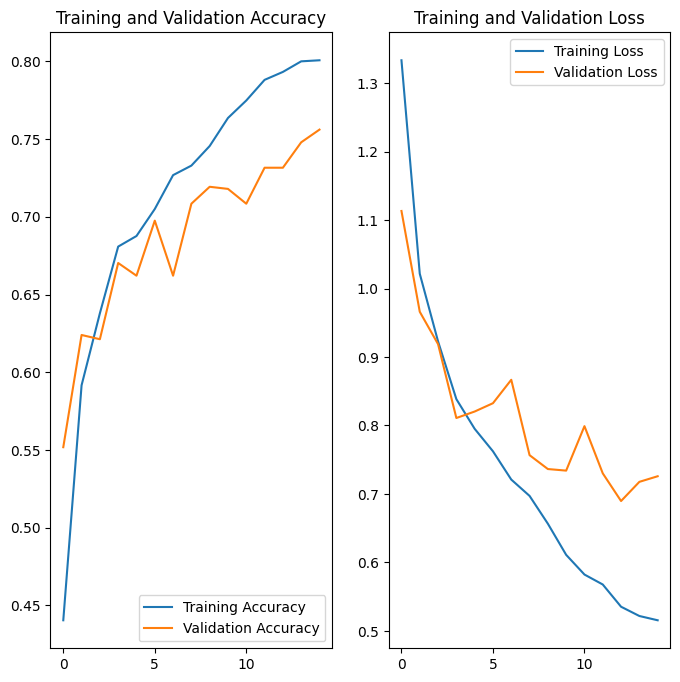

In [72]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

##### 注意保存的模型再次导入推导有问题

In [73]:
model.save('./flower.keras')
model.save('./flower.h5')

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## 生成多个图片以便测试

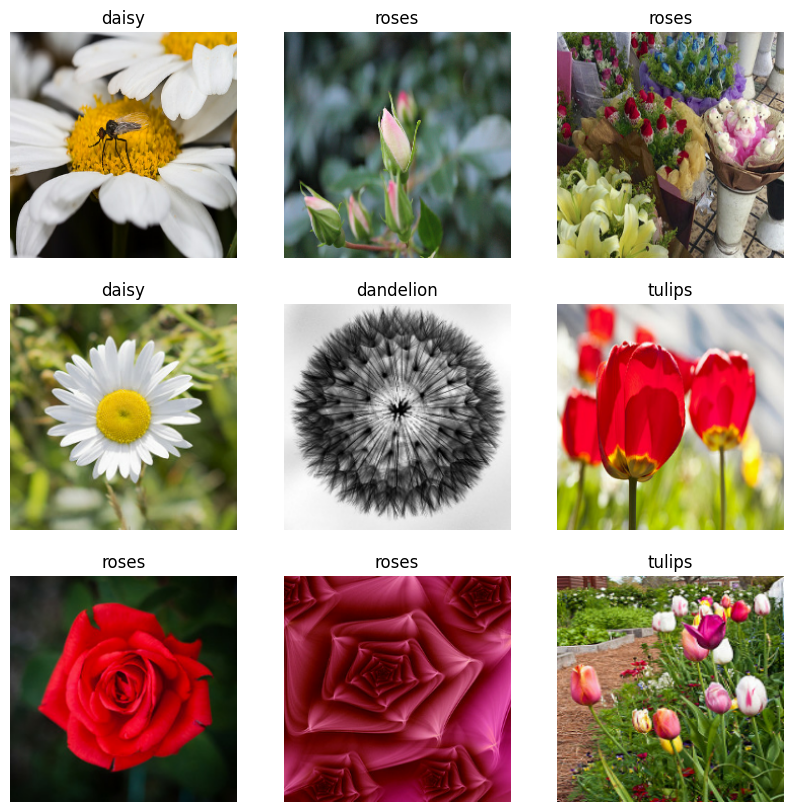

In [74]:
import matplotlib.pyplot as plt
from PIL import Image
#train_ds=train_dataset
sample_names=[]
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    array=images[i].numpy().astype("uint8")
    image = Image.fromarray(array)
    plt.imshow(array)
    image.save('sample'+str(i)+'.png')
    plt.title(class_names[labels[i]])
    plt.axis("off")
    sample_names.append(class_names[labels[i]])

In [75]:
#save sample labels and class names.
import numpy as np
np.savetxt("sample_lab.txt", sample_names, fmt='%s')
np.savetxt("output.txt",class_names, fmt='%s')

## 根据新数据进行预测

使用您的模型对一个未包含在训练集或验证集中的图像进行分类。

注：数据增强层和随机失活层在推断时处于非活动状态。

In [76]:
#sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
#sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    './sample0.png', target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
print(predictions)
#score = tf.nn.softmax(predictions[0])
#print(score)
score=predictions
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 126ms/step
[[9.9742860e-01 2.1521507e-03 5.7401248e-05 3.5262649e-04 9.2343753e-06]]
This image most likely belongs to daisy with a 99.74 percent confidence.


In [77]:
loss, accuracy = model.evaluate(val_ds)
print('Test accuracy :', accuracy)

23/23 [==============================] - 0s 5ms/step - loss: 0.7259 - accuracy: 0.7561
Test accuracy : 0.7561308145523071


##### 利用保存的多张图片测试，预测出错显示红色标题

In [78]:
# 打开文件
sample_names=[]
with open('sample_lab.txt', 'r') as file:
    # 逐行读取
    for line in file:
        # 去除行尾的换行符并处理数据
        data = line.strip()
        # 对数据进行分类处理
        # 例如，打印数据
        if data != "":
            sample_names.append(data)
print(sample_names)

['daisy', 'roses', 'roses', 'daisy', 'dandelion', 'tulips', 'roses', 'roses', 'tulips']


1/1 [==============================] - 0s 14ms/step
[[9.9742860e-01 2.1521507e-03 5.7401248e-05 3.5262649e-04 9.2343753e-06]]
This image most likely belongs to daisy with a 99.74 percent confidence.
0
1/1 [==============================] - 0s 12ms/step
[[0.09016743 0.04855914 0.25715777 0.00254007 0.60157555]]
This image most likely belongs to tulips with a 60.16 percent confidence.
4
1/1 [==============================] - 0s 13ms/step
[[2.2109873e-03 1.5170024e-04 6.5043247e-01 5.4862496e-04 3.4665620e-01]]
This image most likely belongs to roses with a 65.04 percent confidence.
2
1/1 [==============================] - 0s 13ms/step
[[9.9980074e-01 4.9245828e-05 1.2658301e-04 2.2687195e-06 2.1251080e-05]]
This image most likely belongs to daisy with a 99.98 percent confidence.
0
1/1 [==============================] - 0s 13ms/step
[[0.08000746 0.57736516 0.26590475 0.00483323 0.07188935]]
This image most likely belongs to dandelion with a 57.74 percent confidence.
1
1/1 [===============

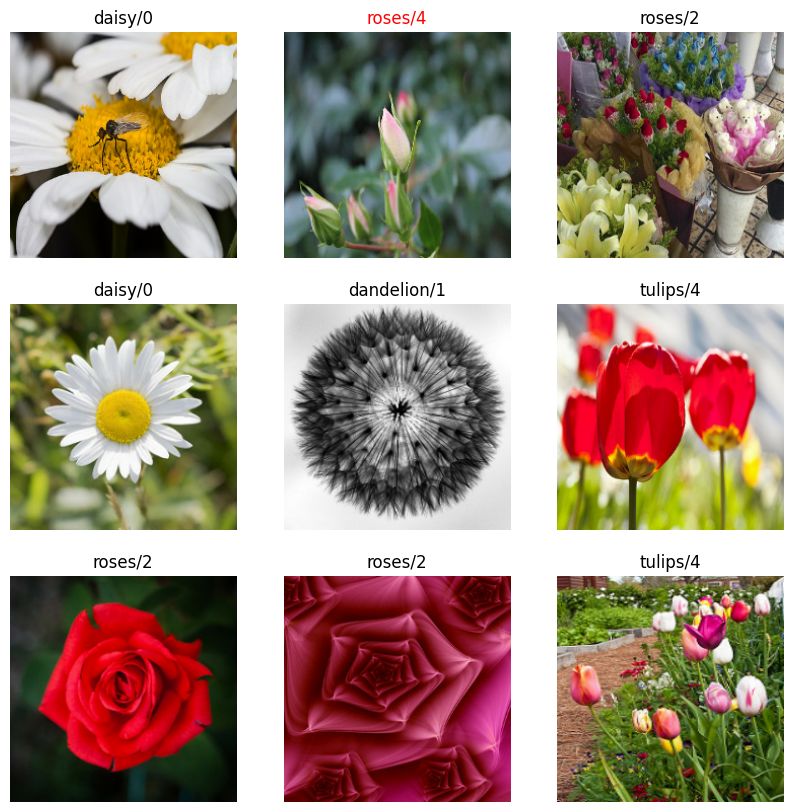

In [79]:
import matplotlib.pyplot as plt
from PIL import Image
labels=sample_names
plt.figure(figsize=(10, 10))
color='black'
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    filename='./sample'+str(i)+'.png'
    img = tf.keras.utils.load_img(
        filename, target_size=(img_height, img_width)
    )
    img_arr = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_arr, 0) # Create a batch
    predictions = model.predict(img_array)
    print(predictions)
    #score = tf.nn.softmax(predictions[0])
    score=predictions
    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(score)], 100 * np.max(score))
    )
    #array=images[i].numpy().astype("uint8")
    #image = Image.fromarray(array)
    result=np.argmax(score)
    print(result)
    img_arr=img_arr/255
    plt.imshow(img_arr)
    if class_names[result] == sample_names[i]:
        color='black'
    else:
        color='red'
    plt.title(labels[i]+"/"+str(result),color=color)
    plt.axis("off")


In [80]:
##### 使用训练集中的多张图片测试，预测出错显示红色标题

tf.Tensor([0 4 4 0 1 0 1 0 3 1 2 2 4 1 4 4 0 3 1 2 2 2 2 4 4 4 1 1 4 3 2 2], shape=(32,), dtype=int32)
1/1 [==============================] - 0s 13ms/step
[[0.9373536  0.00890057 0.01553643 0.03225475 0.00595465]]
0
1/1 [==============================] - 0s 13ms/step
[[0.06278628 0.10263093 0.06814644 0.02629598 0.7401404 ]]
4
1/1 [==============================] - 0s 12ms/step
[[1.8074873e-04 9.8971134e-07 7.3041534e-03 2.9443806e-06 9.9251115e-01]]
4
1/1 [==============================] - 0s 13ms/step
[[0.5263224  0.03467631 0.33815342 0.01258026 0.08826754]]
0
1/1 [==============================] - 0s 12ms/step
[[2.3470379e-03 9.9614751e-01 7.0833397e-04 4.0151135e-06 7.9297269e-04]]
1
1/1 [==============================] - 0s 12ms/step
[[9.9984467e-01 9.0483452e-05 4.6245990e-05 3.8603062e-07 1.8216928e-05]]
0
1/1 [==============================] - 0s 13ms/step
[[0.2876535  0.60058105 0.05581851 0.00430222 0.05164471]]
1
1/1 [==============================] - 0s 13ms/step
[[9.99022

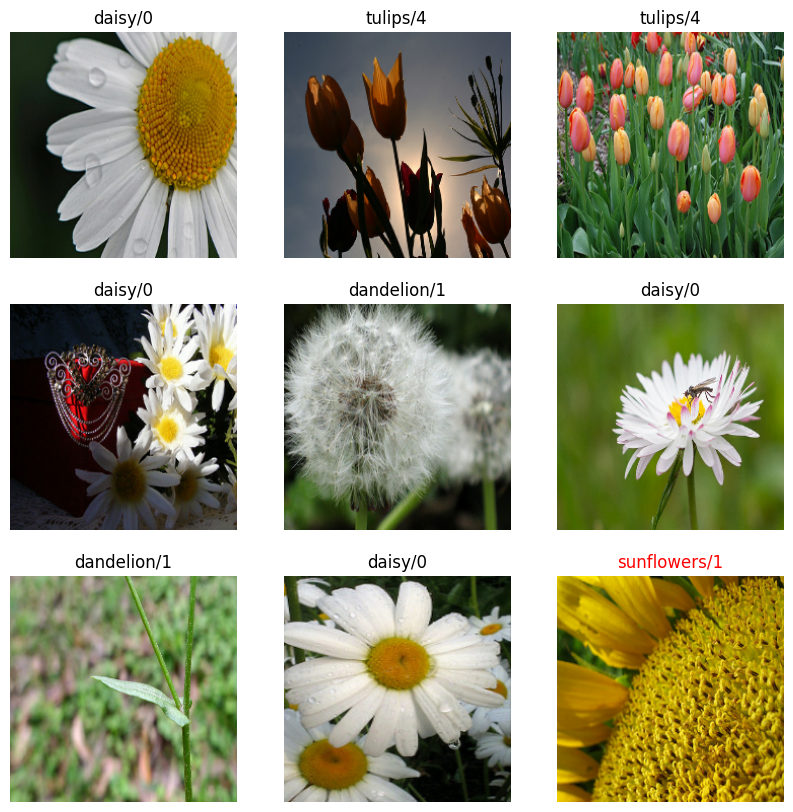

In [81]:
import matplotlib.pyplot as plt
from PIL import Image
#train_ds=train_dataset
plt.figure(figsize=(10, 10))
sample_names=[]
color='black'
for images, labels in train_ds.take(1):
  print(labels)
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    array=images[i].numpy().astype("uint8")
    image = Image.fromarray(array)
    plt.imshow(array)
    reimg=np.reshape(images[i],(1, )+ images[i].shape)
    #reimg=reimg/255
    result=model.predict(reimg)
    print(result)
    #score = tf.nn.softmax(result[0])
    #print(score)
    score=result
    result=np.argmax(score)
    print(result)
    if result == labels[i]:
        color='black'
    else:
        color='red'
    plt.title(class_names[labels[i]]+"/"+str(result),color=color)
    plt.axis("off")

## 实用 TensorFlow Lite

TensorFlow Lite 是一组工具，可帮助开发者在移动设备、嵌入式设备和边缘设备上运行模型，从而实现设备端机器学习。

### 将 Keras 序贯模型转换为 TensorFlow Lite 模型

要将经过训练的模型与设备端应用程序一起使用，请首先[将其转换](https://tensorflow.google.cn/lite/models/convert)为更小、更高效的模型格式，称为 [TensorFlow Lite](https://tensorflow.google.cn/lite/) 模型。

在此示例中，采用经过训练的 Keras 序贯模型并使用 `tf.lite.TFLiteConverter.from_keras_model` 生成 [TensorFlow Lite](https://tensorflow.google.cn/lite/) 模型：

In [82]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpqh71nhm4/assets


INFO:tensorflow:Assets written to: /tmp/tmpqh71nhm4/assets
2025-08-29 08:17:30.432634: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2025-08-29 08:17:30.432675: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2025-08-29 08:17:30.432791: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpqh71nhm4
2025-08-29 08:17:30.434537: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2025-08-29 08:17:30.434548: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpqh71nhm4
2025-08-29 08:17:30.439983: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2025-08-29 08:17:30.495229: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpqh71nhm4
2025-08-29 08:17:30.505893: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

您在上一步中保存的 TensorFlow Lite 模型可以包含多个函数签名。 Keras 模型转换器 API 会自动使用默认签名。详细了解 [TensorFlow Lite 签名](https://tensorflow.google.cn/lite/guide/signatures)。

### 运行 TensorFlow Lite 模型

您可以通过 `tf.lite.Interpreter` 类在 Python 中访问 TensorFlow Lite 保存的模型签名。

使用 `Interpreter` 加载模型：

In [83]:
filename='./sample0.png'
img = tf.keras.utils.load_img(
    filename, target_size=(img_height, img_width)
)
img_arr = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_arr, 0) # Create a batch

In [84]:
TF_MODEL_FILE_PATH = './tflite_models_qt/model.tflite' # The default path to the saved TensorFlow Lite model

interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)

打印转换后的模型中的签名以获得输入（和输出）的名称：


In [85]:
interpreter.get_signature_list()

{'serving_default': {'inputs': ['sequential_1_input'], 'outputs': ['outputs']}}

在此示例中，您有一个名为 `serving_default` 的默认签名。此外，`'inputs'` 的名称是 `'sequential_1_input'`，而 `'outputs'` 的名称为 `'outputs'`。如本教程前面所述，您可以在运行 `Model.summary` 时查找这些第一个和最后一个 Keras 层名称。

现在，您可以使用 `tf.lite.Interpreter.get_signature_runner` 通过传递签名名称对示例图像执行推断来测试加载的 TensorFlow 模型，如下所示：

In [86]:
classify_lite = interpreter.get_signature_runner('serving_default')
classify_lite

与您在本教程前面所做的类似，您可以使用 TensorFlow Lite 模型对未包含在训练集或验证集中的图像进行分类。

您已经对该图像进行了张量化并将其保存为 `img_array`。现在，将其传递给已加载的 TensorFlow Lite 模型 (`predictions_lite`) 的第一个参数（`'inputs'` 的名称），计算 Softmax 激活，然后打印具有最高计算概率的类的预测。

In [87]:
predictions_lite = classify_lite(sequential_1_input=img_array)['outputs']
#score_lite = tf.nn.softmax(predictions_lite)
print(predictions_lite)
score_lite = predictions_lite 

[[0.0000000e+00 1.0000000e+00 1.5046965e-32 7.8816741e-31 6.3850361e-32]]


In [88]:
print("Label name is {}",class_names[1])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score_lite)], 100 * np.max(score_lite))
)

Label name is {} dandelion
This image most likely belongs to dandelion with a 100.00 percent confidence.


Lite 模型生成的预测应该与原始模型生成的预测几乎相同：

In [89]:
print(np.max(np.abs(predictions - predictions_lite)))

0.9951614


在 `'daisy'`、`'dandelion'`、`'roses'`、`'sunflowers'` 和 `'tulips'` 这五个类中，模型应该预测图像属于向日葵，这与 TensorFlow Lite 转换之前的结果相同。


In [90]:
##### 生成量化模型(8位整数模型有问题，16位浮点数可行)

In [91]:
import tensorflow as tf
converter = tf.lite.TFLiteConverter.from_keras_model(model)

optimization = tf.lite.Optimize.DEFAULT
converter.optimizations = [optimization]
#use float16 instead of uint8
converter.target_spec.supported_types = [tf.float16]
tflite_model = converter.convert()

import pathlib

tflite_models_dir = pathlib.Path("./tflite_models_qt/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)
tflite_model_file = tflite_models_dir/"model.tflite"
tflite_model_file.write_bytes(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmphhbnocm_/assets


INFO:tensorflow:Assets written to: /tmp/tmphhbnocm_/assets
2025-08-29 08:18:26.507328: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2025-08-29 08:18:26.507369: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2025-08-29 08:18:26.507485: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmphhbnocm_
2025-08-29 08:18:26.508762: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2025-08-29 08:18:26.508773: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmphhbnocm_
2025-08-29 08:18:26.512024: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2025-08-29 08:18:26.568687: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmphhbnocm_
2025-08-29 08:18:26.579138: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

12899600

In [100]:
from PIL import Image
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
IMAGE_SHAPE=224
SAMPLE_NAME= 'sample6.png'
IMG_CHANNELS=3
tflite_model_file = 'tflite_models_qt/model.tflite'          
interpreter = tf.lite.Interpreter(model_path=tflite_model_file)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

Im = Image.open(SAMPLE_NAME)
Im_resized = Im.resize((IMAGE_SHAPE, IMAGE_SHAPE))
Im = np.asarray(Im_resized)

#Im = Im/255

#input_data = np.array(Im, dtype=np.float32)
input_data = Im.astype("float32")
#print(input_data[0:2][0:2])
#reimg=np.reshape(images[i],(1, )+ images[i].shape)
input_data = input_data.reshape(1, input_data.shape[0], input_data.shape[1], IMG_CHANNELS)

interpreter.set_tensor(input_index, input_data)
interpreter.invoke()
predictionval = interpreter.get_tensor(output_index)
prediction = np.argmax(predictionval)


print(predictionval,prediction,class_names[prediction])

[[3.2245782e-11 1.3759094e-09 9.9938500e-01 4.4385551e-11 6.1500043e-04]] 2 roses


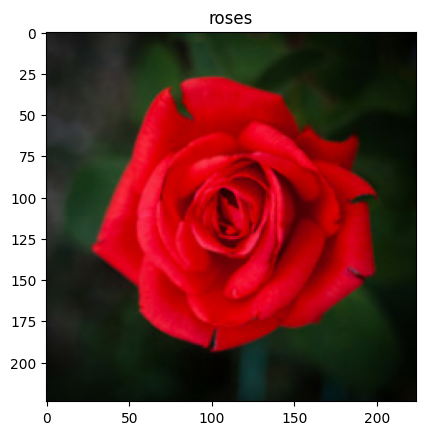

In [101]:
Im = Image.open(SAMPLE_NAME)
plt.imshow(Im)


plt.title(class_names[prediction])
#plt.axis('off')
plt.show()

## 后续步骤

本教程展示了如何训练用于图像分类的模型，对其进行测试，将其转换为 TensorFlow Lite 格式以用于设备端应用（例如图像分类应用），以及使用 Python API 通过 TensorFlow Lite 模型执行推断。

您可以通过[教程](https://tensorflow.google.cn/lite/tutorials)和[指南](https://tensorflow.google.cn/lite/guide)了解有关 TensorFlow Lite 的更多信息。